# Financial News Sentiment Analysis
In this notebook, we will perform sentiment analysis on financial news. The outputs will be classified as positive, negative, or neutral.

In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os
import joblib
import pickle
import re
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# NOTE: Run this section only once to download NLTK datasets
# After running once successfully, you can comment out the section below
"""
# Set the directory for NLTK data
nltk_data_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'nltk_data')
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

# Configure NLTK data directory
nltk.data.path.insert(0, nltk_data_dir)

# Download required NLTK datasets
print("Downloading NLTK datasets...")
for dataset in ['punkt', 'stopwords', 'wordnet', 'omw-1.4']:
    print(f"Downloading {dataset}...")
    nltk.download(dataset, download_dir=nltk_data_dir, quiet=True)
    print(f"{dataset} downloaded.")

# Verify downloaded datasets
print("\nVerifying NLTK datasets...")
try:
    # Test dataset usage
    word_tokenize("Test sentence")
    stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    lemmatizer.lemmatize("testing")
    print("All NLTK datasets successfully loaded and tested.")
except LookupError as e:
    print(f"Error: {str(e)}")
    print("An error occurred while loading NLTK datasets.")
"""

'\n# Set the directory for NLTK data\nnltk_data_dir = os.path.join(os.path.dirname(os.path.abspath(\'__file__\')), \'nltk_data\')\nif not os.path.exists(nltk_data_dir):\n    os.makedirs(nltk_data_dir)\n\n# Configure NLTK data directory\nnltk.data.path.insert(0, nltk_data_dir)\n\n# Download required NLTK datasets\nprint("Downloading NLTK datasets...")\nfor dataset in [\'punkt\', \'stopwords\', \'wordnet\', \'omw-1.4\']:\n    print(f"Downloading {dataset}...")\n    nltk.download(dataset, download_dir=nltk_data_dir, quiet=True)\n    print(f"{dataset} downloaded.")\n\n# Verify downloaded datasets\nprint("\nVerifying NLTK datasets...")\ntry:\n    # Test dataset usage\n    word_tokenize("Test sentence")\n    stopwords.words(\'english\')\n    lemmatizer = WordNetLemmatizer()\n    lemmatizer.lemmatize("testing")\n    print("All NLTK datasets successfully loaded and tested.")\nexcept LookupError as e:\n    print(f"Error: {str(e)}")\n    print("An error occurred while loading NLTK datasets.")\n'

## Loading and Exploring the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('../data/sentiment_data.csv', header=None, names=['text', 'sentiment'])

# Display initial dataset size
print("Initial dataset size:", len(df))

# Remove duplicate entries based on text
duplicate_count = df.duplicated(subset=['text']).sum()
if duplicate_count > 0:
    print(f"\nRemoving {duplicate_count} duplicate records")
    df = df.drop_duplicates(subset=['text'], keep='first')
    print("Dataset size after removing duplicates:", len(df))

# Data cleaning and encoding: map sentiment labels directly to numeric values
def encode_sentiment(s):
    s = str(s).lower().strip()
    if s in ['negative', 'neg', '-1']:
        return 2  # negative -> 2
    elif s in ['neutral', 'neu', '0']:
        return 0  # neutral -> 0
    elif s in ['positive', 'pos', '1']:
        return 1  # positive -> 1
    else:
        return None  # for unknown values

# Apply encoding
df['sentiment_encoded'] = df['sentiment'].apply(encode_sentiment)

# Remove rows with unknown sentiment (None values)
unknown_count = df['sentiment_encoded'].isna().sum()
if unknown_count > 0:
    print(f"\nRemoving {unknown_count} records with unknown sentiment values")
    df = df.dropna(subset=['sentiment_encoded'])

print("\nDataset size after removing unknown labels:", len(df))

# Store the mapping for reference
sentiment_mapping = {
    'negative': 2,
    'neutral': 0,
    'positive': 1
}
print("\nSentiment Label Mapping:")
for sentiment, code in sentiment_mapping.items():
    print(f"{sentiment} -> {code}")

# Convert encoded values to int type
df['sentiment_encoded'] = df['sentiment_encoded'].astype(int)

# Display the distribution of sentiment classes
print("\nDistribution of sentiment classes:")
sentiment_counts = df['sentiment_encoded'].map({2: 'negative', 0: 'neutral', 1: 'positive'}).value_counts()
print(sentiment_counts)

# Display first few rows of the cleaned dataset
print("\nFirst 5 rows of the cleaned dataset:")
print(df[['text', 'sentiment', 'sentiment_encoded']].head())

Initial dataset size: 5843

Removing 520 duplicate records
Dataset size after removing duplicates: 5323

Removing 1 records with unknown sentiment values

Dataset size after removing unknown labels: 5322

Sentiment Label Mapping:
negative -> 2
neutral -> 0
positive -> 1

Distribution of sentiment classes:
sentiment_encoded
neutral     2878
positive    1852
negative     592
Name: count, dtype: int64

First 5 rows of the cleaned dataset:
                                                text sentiment  \
1  The GeoSolutions technology will leverage Bene...  positive   
2  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative   
3  For the last quarter of 2010 , Componenta 's n...  positive   
4  According to the Finnish-Russian Chamber of Co...   neutral   
5  The Swedish buyout firm has sold its remaining...   neutral   

   sentiment_encoded  
1                  1  
2                  2  
3                  1  
4                  0  
5                  0  


## Text Preprocessing
1. Convert to lowercase
2. Remove punctuation
3. Remove stop words
4. Apply lemmatization

In [3]:
# Enhanced text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove stock symbols (e.g., $AAPL, $GOOG)
    text = re.sub(r'\$\w+', '', text)
    
    # Remove numbers with % (percentage)
    text = re.sub(r'\d+%', '', text)
    
    # Remove currency symbols and amounts (e.g., $123.45, €100, £50)
    text = re.sub(r'[$€£¥]\d+(?:\.\d{2})?|\d+(?:\.\d{2})?[$€£¥]', '', text)
    
    # Remove special characters and numbers
    # Keep alphabets and spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization with pos tagging for better accuracy
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]  # First try as verb
    tokens = [lemmatizer.lemmatize(token, pos='n') for token in tokens]  # Then as noun
    
    # Remove short words (length < 3)
    tokens = [token for token in tokens if len(token) > 2]
    
    return ' '.join(tokens)

# Preprocess texts in the dataset
df['processed_text'] = df['text'].apply(preprocess_text)

# Check word count and filter
df['word_count'] = df['processed_text'].apply(lambda x: len(str(x).split()))
original_size = len(df)

# Remove examples with less than 4 words
df = df[df['word_count'] >= 4]

print(f"Original dataset size: {original_size}")
print(f"Filtered dataset size: {len(df)}")
print(f"Number of removed examples: {original_size - len(df)}")

# Display examples of processed texts with original for comparison
print("\nExamples of processed texts:")
df_comparison = pd.DataFrame({
    'Original Text': df['text'],
    'Processed Text': df['processed_text'],
    'Word Count': df['word_count']
})
print(df_comparison.head().to_string())

Original dataset size: 5322
Filtered dataset size: 5080
Number of removed examples: 242

Examples of processed texts:
                                                                                                                                                                                                                Original Text                                                                                                                                                                       Processed Text  Word Count
1  The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .  geosolutions technology leverage benefon gps solution provide location base search technology community platform location relevant multimedia content new powerful commercial model          21
3                           For the last quarter of 

## Model Comparison
1. Logistic Regression
2. Random Forest Classifier
3. Support Vector Machine (SVM)
4. Naive Bayes
5. XGBoost

Each model will be evaluated using:
- Accuracy
- Precision, Recall, F1-Score
- Confusion Matrix

## Data Split and Feature Engineering

In [4]:
# First, let's check class distribution
print("Class distribution before sampling:")
print(df['sentiment'].value_counts())
print("\nMinimum samples per class:", df['sentiment'].value_counts().min())

# Remove classes with too few samples (less than 2)
min_samples = 2
value_counts = df['sentiment'].value_counts()
valid_classes = value_counts[value_counts >= min_samples].index
df_filtered = df[df['sentiment'].isin(valid_classes)].copy()

print("\nClass distribution after filtering rare classes:")
print(df_filtered['sentiment'].value_counts())

Class distribution before sampling:
sentiment
neutral     2770
positive    1754
negative     556
Name: count, dtype: int64

Minimum samples per class: 556

Class distribution after filtering rare classes:
sentiment
neutral     2770
positive    1754
negative     556
Name: count, dtype: int64


In [5]:
# Perform train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    df_filtered['processed_text'], 
    df_filtered['sentiment_encoded'],
    test_size=0.25, 
    random_state=9,
    stratify=df_filtered['sentiment_encoded']
)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

Training set size: 3810
Test set size: 1270


In [6]:
# TF-IDF Vectorization with enhanced parameters
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.7,  # Ignore terms that appear in more than 95% of documents
    ngram_range=(1, 2),  # Include both unigrams and bigrams
    strip_accents='unicode',
    norm='l2'
)

# Transform the text data and convert to dense arrays
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

print("\nFeature matrix shape:")
print("Training set:", X_train_tfidf.shape)
print("Test set:", X_test_tfidf.shape)


Feature matrix shape:
Training set: (3810, 5000)
Test set: (1270, 5000)


In [ ]:
with open("../models/tfidf_vector.pkl", "wb") as file:
    pickle.dump(tfidf, file)

['../models/tfidf_vector.joblib']


Training Logistic Regression...
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)

Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.16      0.25       139

    accuracy                           0.75      1270
   macro avg       0.71      0.58      0.60      1270
weighted avg       0.74      0.75      0.72      1270


Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.


Training Logistic Regression...
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)

Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.16      0.25       139

    accuracy                           0.75      1270
   macro avg       0.71      0.58      0.60      1270
weighted avg       0.74      0.75      0.72      1270


Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.

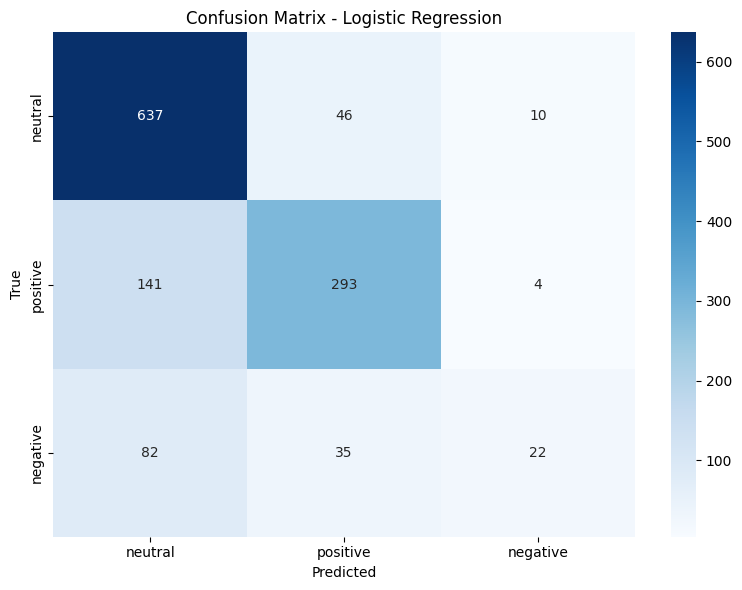


Training Logistic Regression...
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)

Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.16      0.25       139

    accuracy                           0.75      1270
   macro avg       0.71      0.58      0.60      1270
weighted avg       0.74      0.75      0.72      1270


Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.

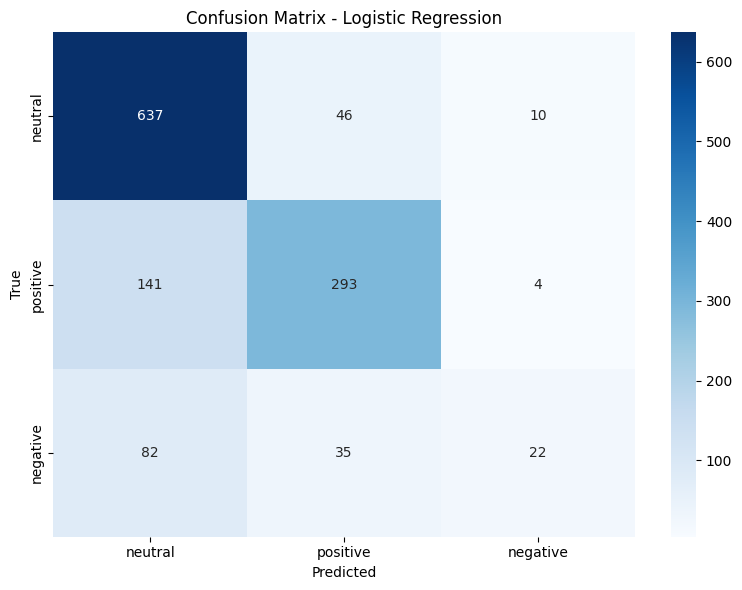


Training Random Forest...
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)

Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31       139

    accuracy                           0.74      1270
   macro avg       0.68      0.59      0.61      1270
weighted avg       0.73      0.74      0.72      1270


Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31      


Training Logistic Regression...
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)

Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.16      0.25       139

    accuracy                           0.75      1270
   macro avg       0.71      0.58      0.60      1270
weighted avg       0.74      0.75      0.72      1270


Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.

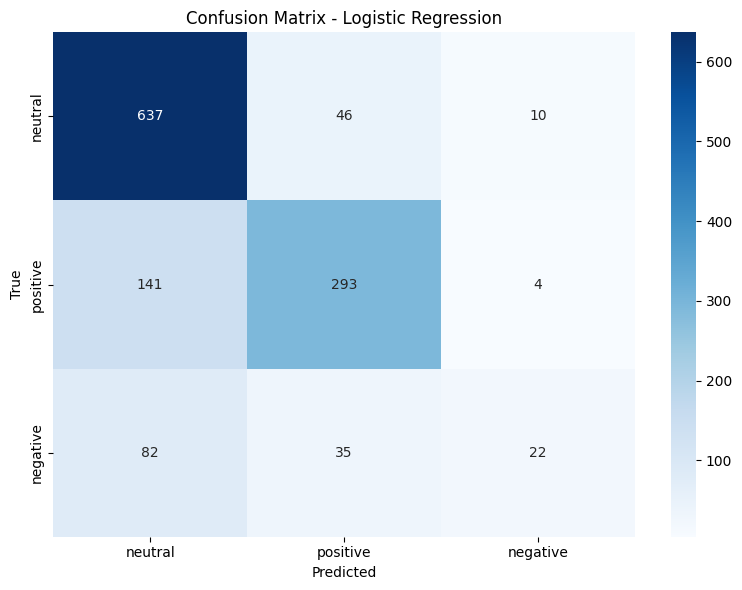


Training Random Forest...
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)

Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31       139

    accuracy                           0.74      1270
   macro avg       0.68      0.59      0.61      1270
weighted avg       0.73      0.74      0.72      1270


Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31      

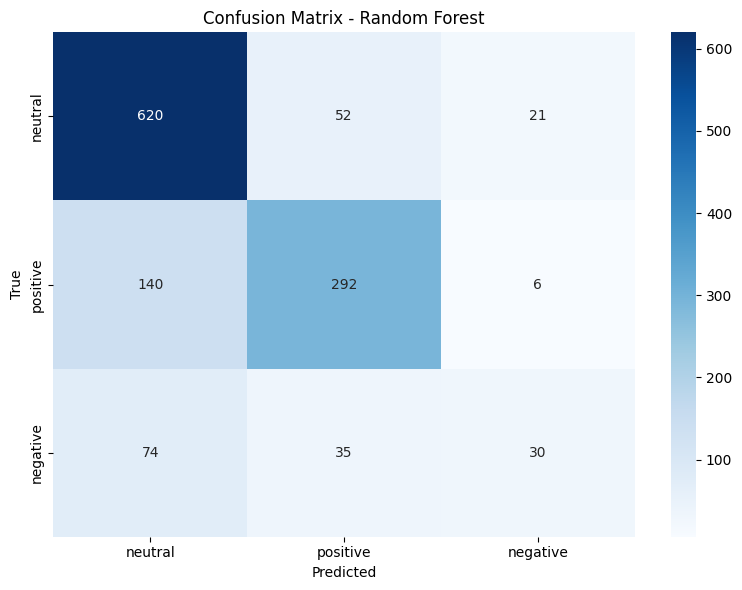


Training Logistic Regression...
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)

Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.16      0.25       139

    accuracy                           0.75      1270
   macro avg       0.71      0.58      0.60      1270
weighted avg       0.74      0.75      0.72      1270


Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.

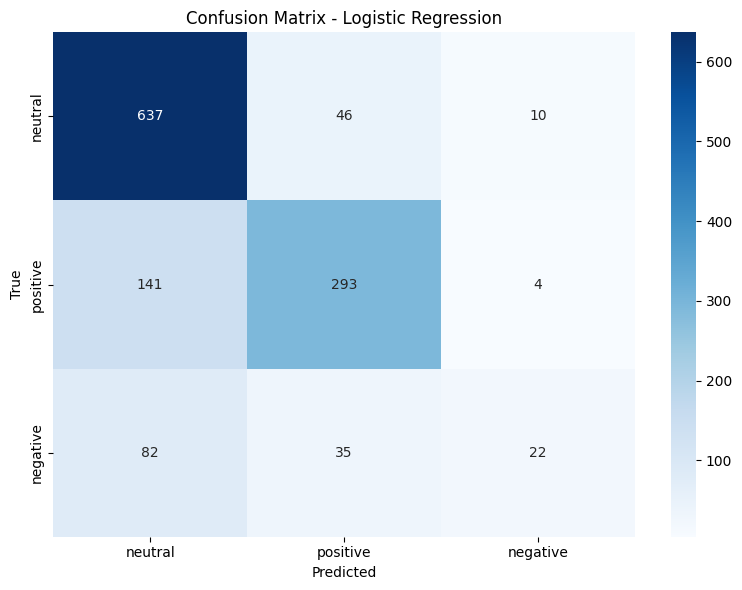


Training Random Forest...
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)

Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31       139

    accuracy                           0.74      1270
   macro avg       0.68      0.59      0.61      1270
weighted avg       0.73      0.74      0.72      1270


Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31      

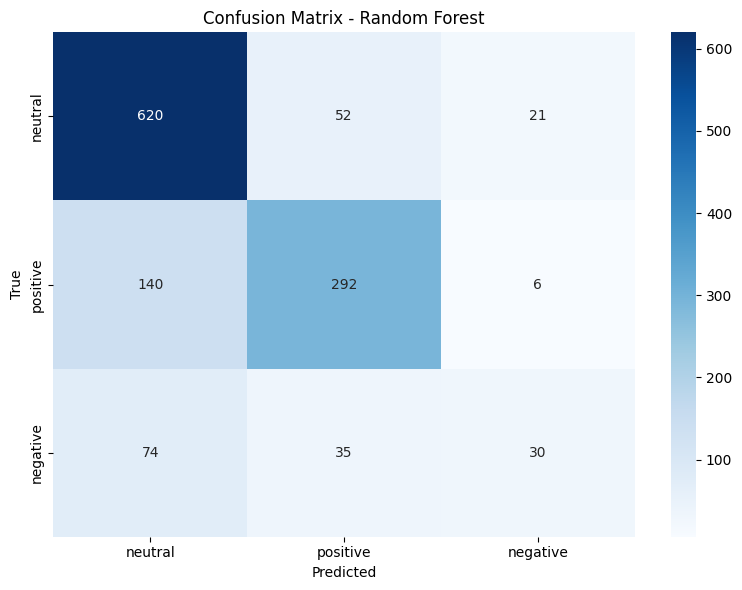


Training SVM...
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)

SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy                           0.74      1270
   macro avg       0.70      0.56      0.58      1270
weighted avg       0.73      0.74      0.71      1270


SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy            


Training Logistic Regression...
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)

Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.16      0.25       139

    accuracy                           0.75      1270
   macro avg       0.71      0.58      0.60      1270
weighted avg       0.74      0.75      0.72      1270


Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.

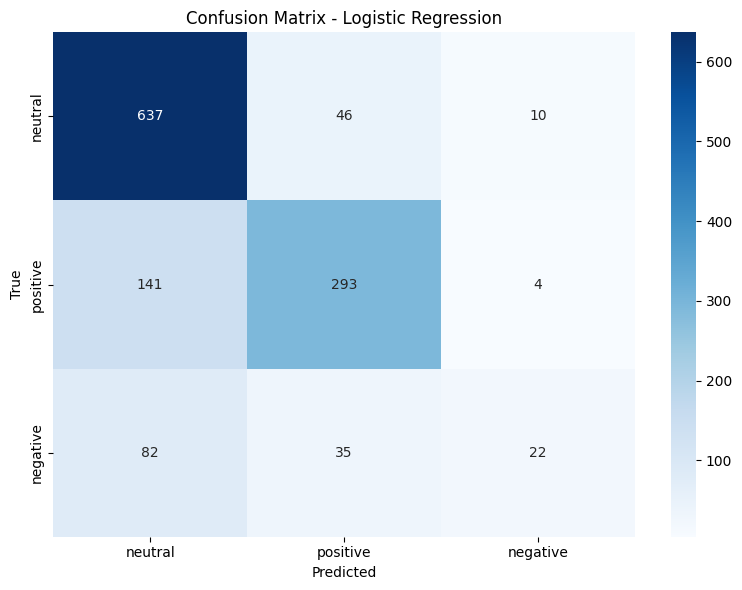


Training Random Forest...
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)

Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31       139

    accuracy                           0.74      1270
   macro avg       0.68      0.59      0.61      1270
weighted avg       0.73      0.74      0.72      1270


Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31      

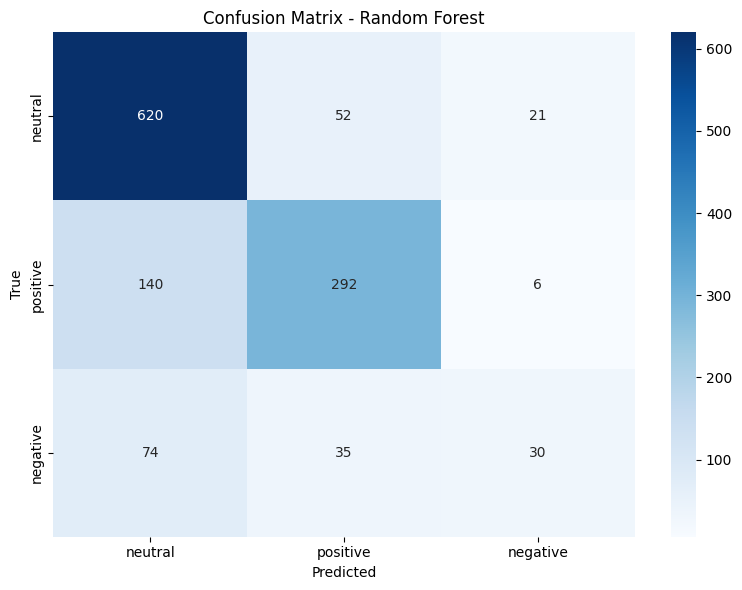


Training SVM...
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)

SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy                           0.74      1270
   macro avg       0.70      0.56      0.58      1270
weighted avg       0.73      0.74      0.71      1270


SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy            

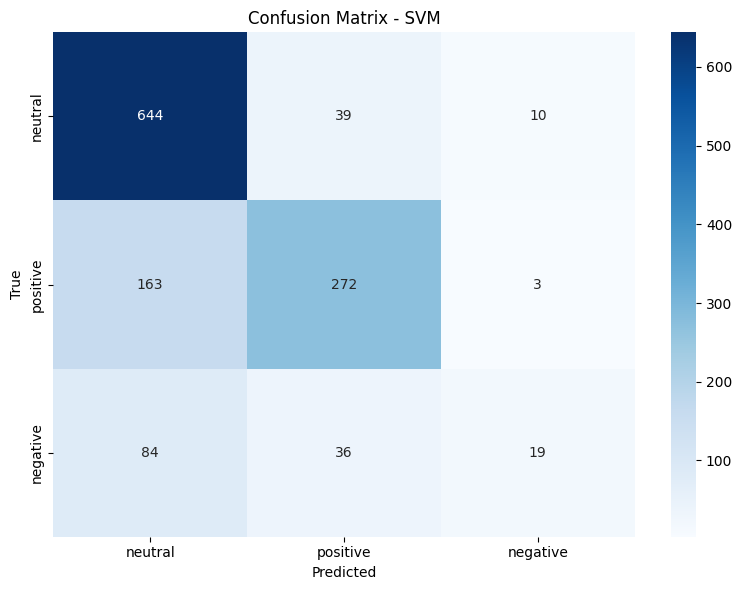


Training Logistic Regression...
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)

Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.16      0.25       139

    accuracy                           0.75      1270
   macro avg       0.71      0.58      0.60      1270
weighted avg       0.74      0.75      0.72      1270


Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.

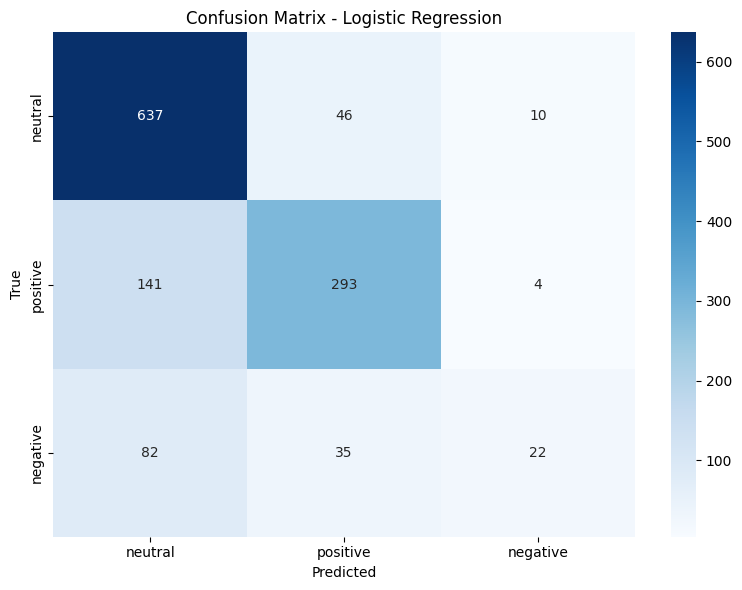


Training Random Forest...
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)

Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31       139

    accuracy                           0.74      1270
   macro avg       0.68      0.59      0.61      1270
weighted avg       0.73      0.74      0.72      1270


Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31      

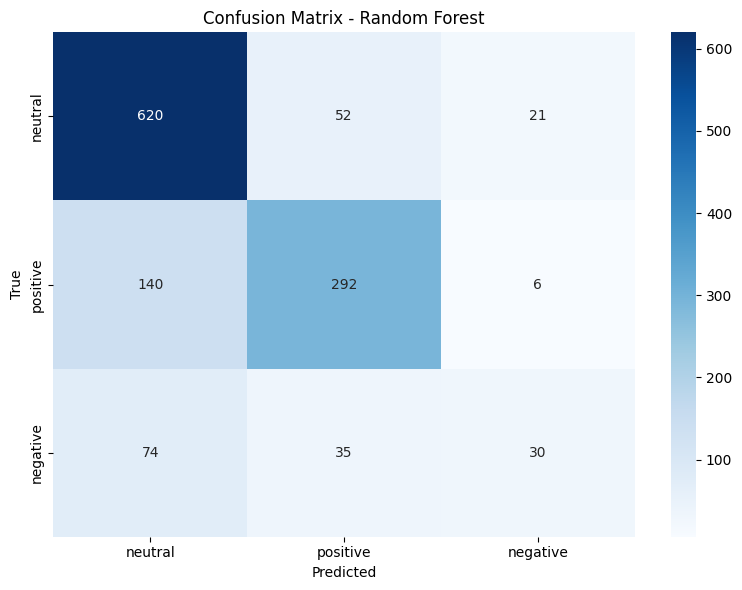


Training SVM...
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)

SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy                           0.74      1270
   macro avg       0.70      0.56      0.58      1270
weighted avg       0.73      0.74      0.71      1270


SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy            

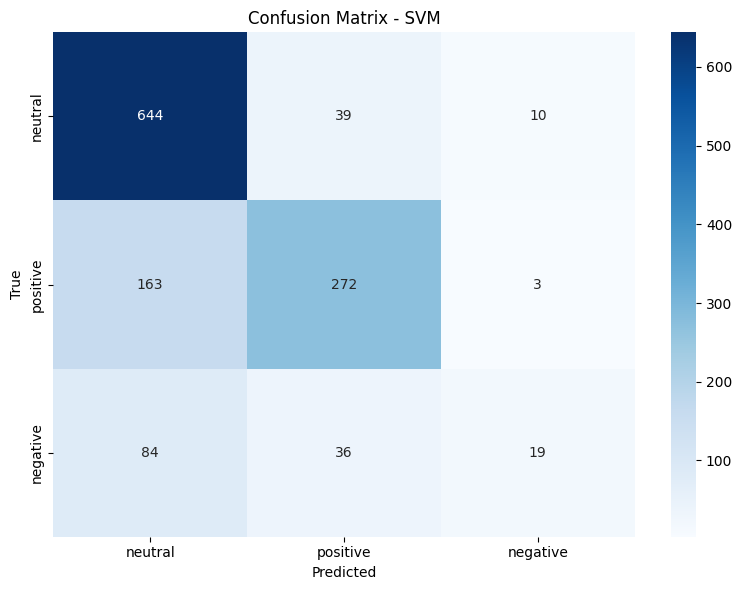


Training Naive Bayes...
Cross-validation scores: [0.68503937 0.71128609 0.70603675 0.68766404 0.70209974]
Mean CV accuracy: 0.6984 (+/- 0.0206)

Naive Bayes Results:
Test Accuracy: 0.7118

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       693
           1       0.70      0.60      0.64       438
           2       0.86      0.04      0.08       139

    accuracy                           0.71      1270
   macro avg       0.76      0.52      0.51      1270
weighted avg       0.73      0.71      0.67      1270

Cross-validation scores: [0.68503937 0.71128609 0.70603675 0.68766404 0.70209974]
Mean CV accuracy: 0.6984 (+/- 0.0206)

Naive Bayes Results:
Test Accuracy: 0.7118

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       693
           1       0.70      0.60      0.64       438
           2       0.86      0.04      0.08       139




Training Logistic Regression...
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)

Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.16      0.25       139

    accuracy                           0.75      1270
   macro avg       0.71      0.58      0.60      1270
weighted avg       0.74      0.75      0.72      1270


Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.

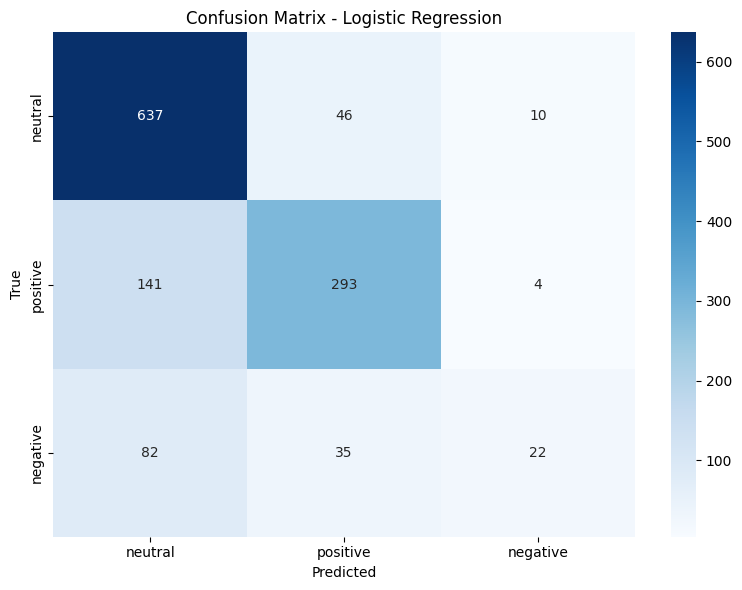


Training Random Forest...
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)

Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31       139

    accuracy                           0.74      1270
   macro avg       0.68      0.59      0.61      1270
weighted avg       0.73      0.74      0.72      1270


Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31      

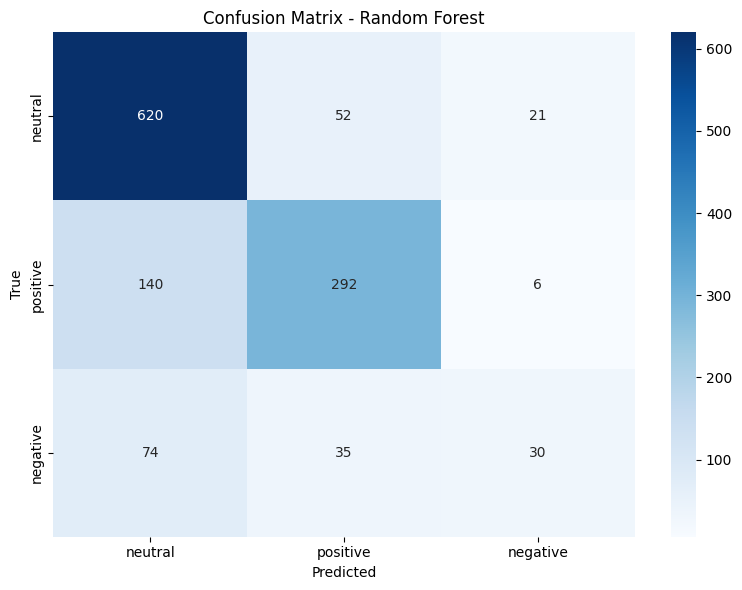


Training SVM...
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)

SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy                           0.74      1270
   macro avg       0.70      0.56      0.58      1270
weighted avg       0.73      0.74      0.71      1270


SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy            

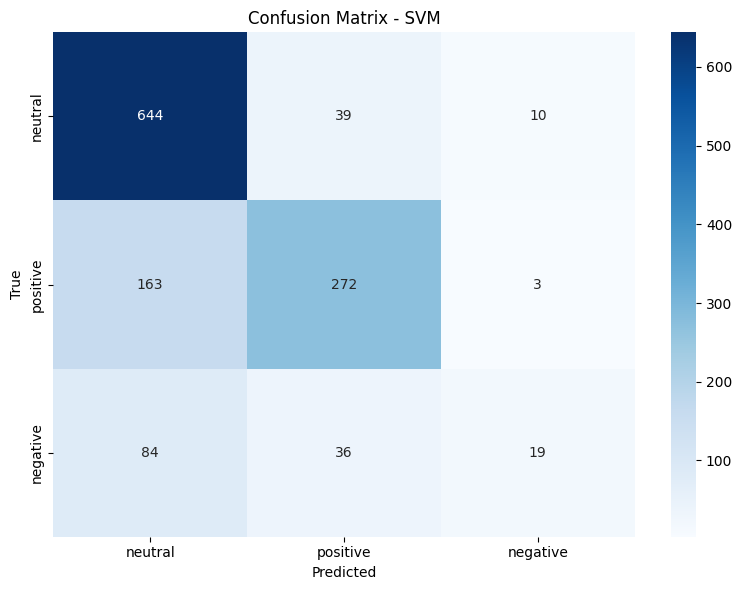


Training Naive Bayes...
Cross-validation scores: [0.68503937 0.71128609 0.70603675 0.68766404 0.70209974]
Mean CV accuracy: 0.6984 (+/- 0.0206)

Naive Bayes Results:
Test Accuracy: 0.7118

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       693
           1       0.70      0.60      0.64       438
           2       0.86      0.04      0.08       139

    accuracy                           0.71      1270
   macro avg       0.76      0.52      0.51      1270
weighted avg       0.73      0.71      0.67      1270

Cross-validation scores: [0.68503937 0.71128609 0.70603675 0.68766404 0.70209974]
Mean CV accuracy: 0.6984 (+/- 0.0206)

Naive Bayes Results:
Test Accuracy: 0.7118

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       693
           1       0.70      0.60      0.64       438
           2       0.86      0.04      0.08       139



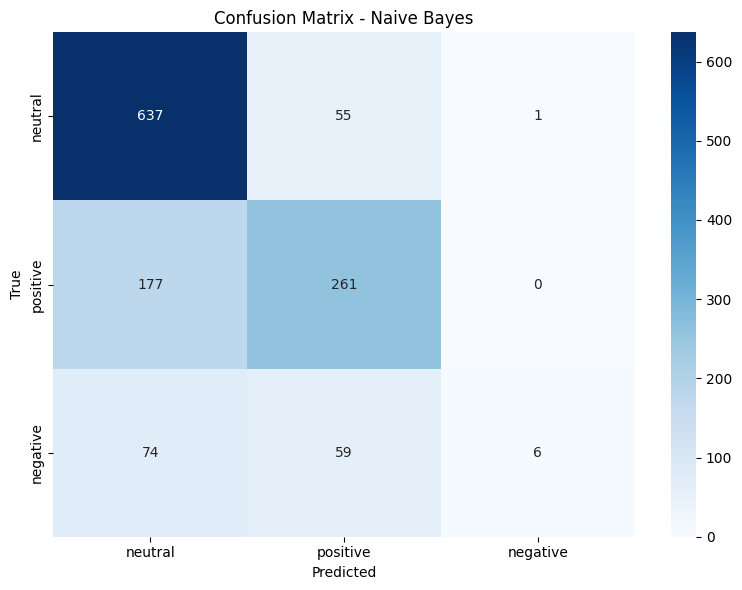


Training Logistic Regression...
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)

Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.16      0.25       139

    accuracy                           0.75      1270
   macro avg       0.71      0.58      0.60      1270
weighted avg       0.74      0.75      0.72      1270


Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.

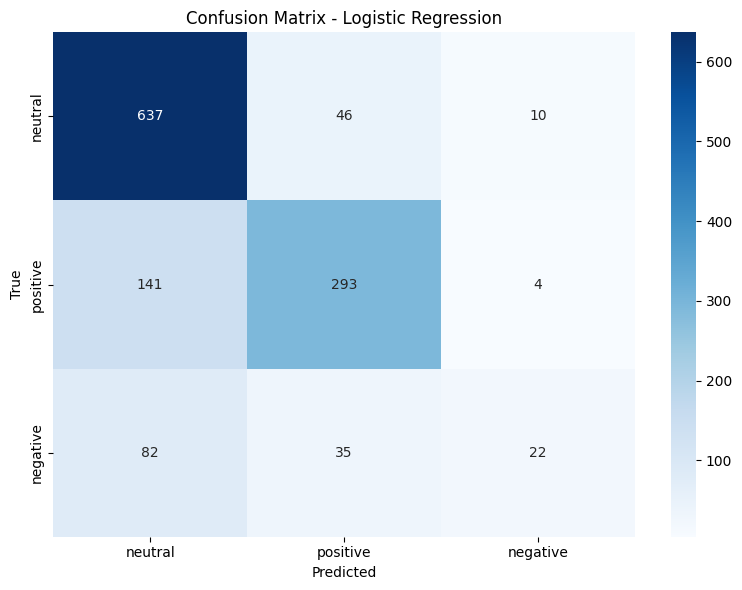


Training Random Forest...
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)

Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31       139

    accuracy                           0.74      1270
   macro avg       0.68      0.59      0.61      1270
weighted avg       0.73      0.74      0.72      1270


Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31      

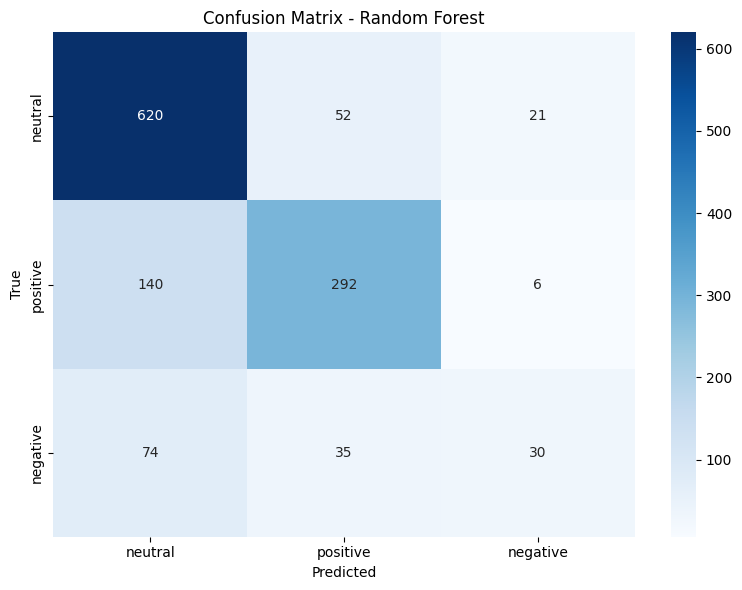


Training SVM...
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)

SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy                           0.74      1270
   macro avg       0.70      0.56      0.58      1270
weighted avg       0.73      0.74      0.71      1270


SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy            

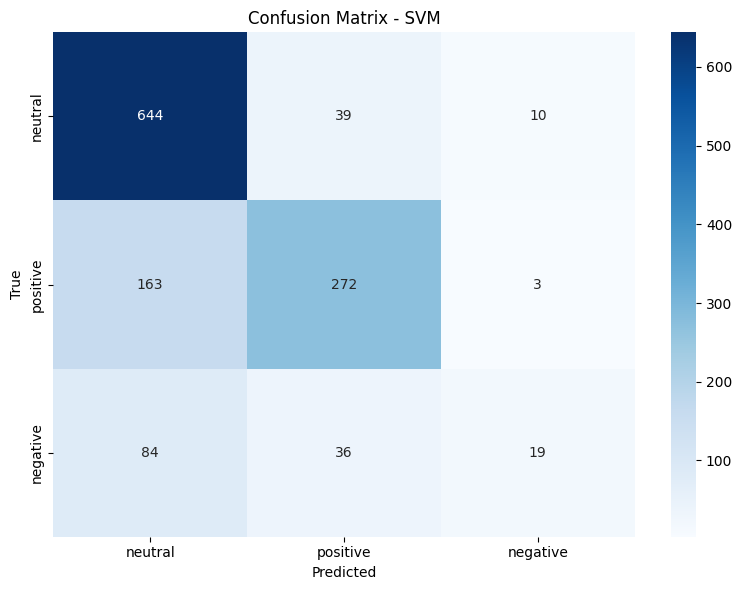


Training Naive Bayes...
Cross-validation scores: [0.68503937 0.71128609 0.70603675 0.68766404 0.70209974]
Mean CV accuracy: 0.6984 (+/- 0.0206)

Naive Bayes Results:
Test Accuracy: 0.7118

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       693
           1       0.70      0.60      0.64       438
           2       0.86      0.04      0.08       139

    accuracy                           0.71      1270
   macro avg       0.76      0.52      0.51      1270
weighted avg       0.73      0.71      0.67      1270

Cross-validation scores: [0.68503937 0.71128609 0.70603675 0.68766404 0.70209974]
Mean CV accuracy: 0.6984 (+/- 0.0206)

Naive Bayes Results:
Test Accuracy: 0.7118

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       693
           1       0.70      0.60      0.64       438
           2       0.86      0.04      0.08       139



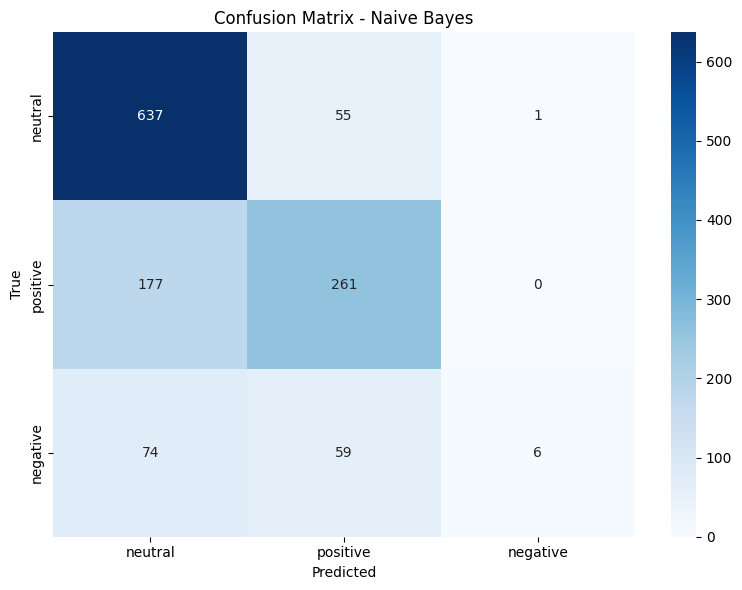


Training XGBoost...
Cross-validation scores: [0.70603675 0.72834646 0.69160105 0.72965879 0.70341207]
Mean CV accuracy: 0.7118 (+/- 0.0297)
Cross-validation scores: [0.70603675 0.72834646 0.69160105 0.72965879 0.70341207]
Mean CV accuracy: 0.7118 (+/- 0.0297)

XGBoost Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.78      0.64      0.70       438
           2       0.47      0.25      0.33       139

    accuracy                           0.74      1270
   macro avg       0.66      0.60      0.61      1270
weighted avg       0.72      0.74      0.72      1270


XGBoost Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.78      0.64      0.70       438
           2       0.47      0.25      0.33       139

    accuracy


Training Logistic Regression...
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)

Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.16      0.25       139

    accuracy                           0.75      1270
   macro avg       0.71      0.58      0.60      1270
weighted avg       0.74      0.75      0.72      1270


Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.

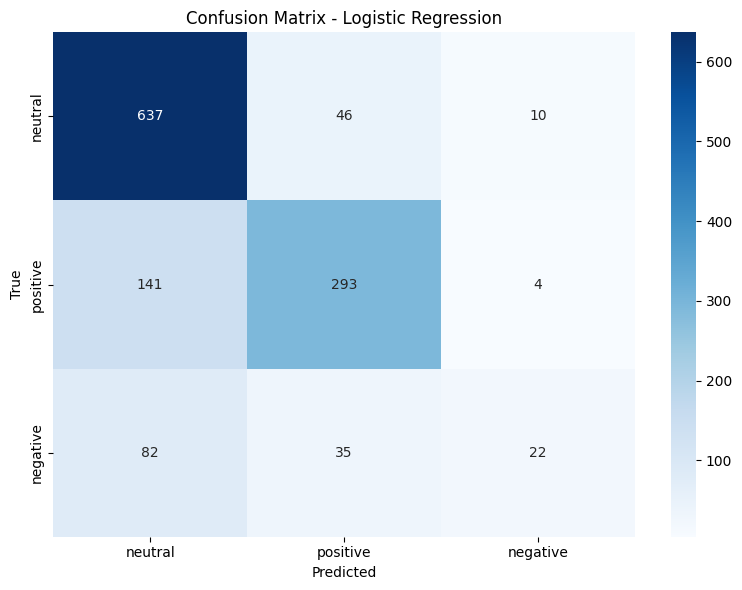


Training Random Forest...
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)

Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31       139

    accuracy                           0.74      1270
   macro avg       0.68      0.59      0.61      1270
weighted avg       0.73      0.74      0.72      1270


Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31      

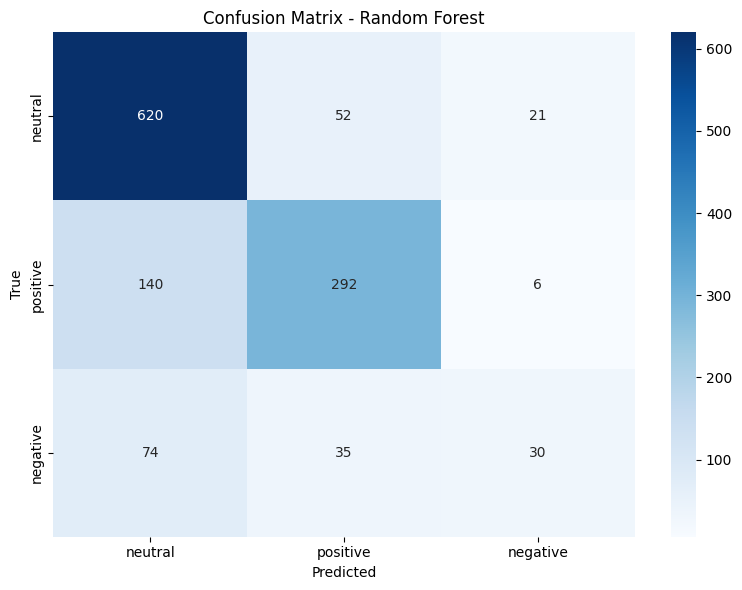


Training SVM...
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)

SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy                           0.74      1270
   macro avg       0.70      0.56      0.58      1270
weighted avg       0.73      0.74      0.71      1270


SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy            

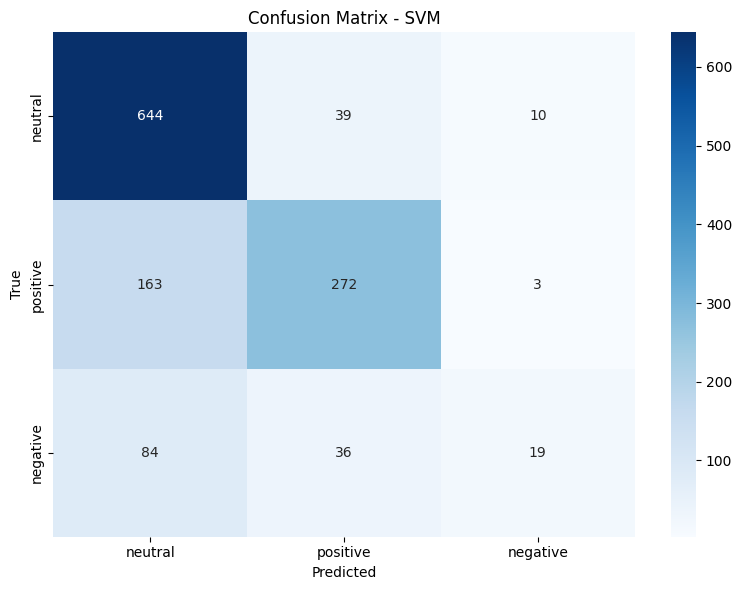


Training Naive Bayes...
Cross-validation scores: [0.68503937 0.71128609 0.70603675 0.68766404 0.70209974]
Mean CV accuracy: 0.6984 (+/- 0.0206)

Naive Bayes Results:
Test Accuracy: 0.7118

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       693
           1       0.70      0.60      0.64       438
           2       0.86      0.04      0.08       139

    accuracy                           0.71      1270
   macro avg       0.76      0.52      0.51      1270
weighted avg       0.73      0.71      0.67      1270

Cross-validation scores: [0.68503937 0.71128609 0.70603675 0.68766404 0.70209974]
Mean CV accuracy: 0.6984 (+/- 0.0206)

Naive Bayes Results:
Test Accuracy: 0.7118

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       693
           1       0.70      0.60      0.64       438
           2       0.86      0.04      0.08       139



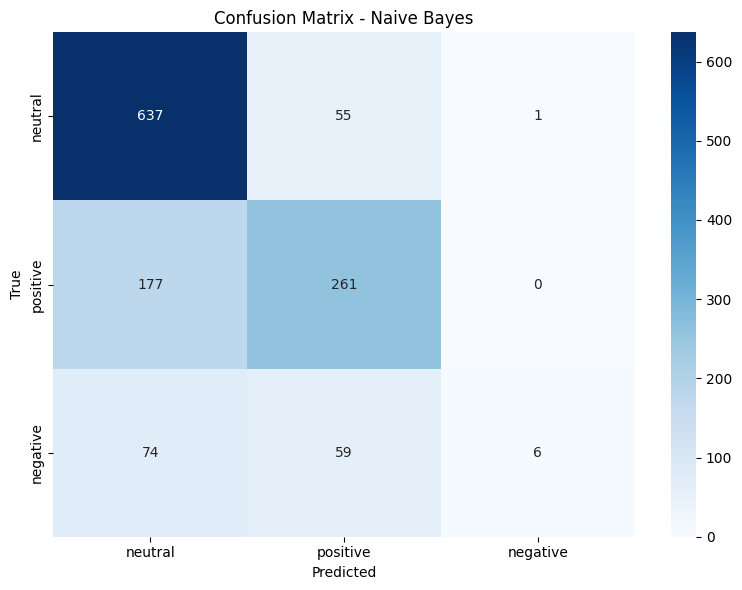


Training XGBoost...
Cross-validation scores: [0.70603675 0.72834646 0.69160105 0.72965879 0.70341207]
Mean CV accuracy: 0.7118 (+/- 0.0297)
Cross-validation scores: [0.70603675 0.72834646 0.69160105 0.72965879 0.70341207]
Mean CV accuracy: 0.7118 (+/- 0.0297)

XGBoost Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.78      0.64      0.70       438
           2       0.47      0.25      0.33       139

    accuracy                           0.74      1270
   macro avg       0.66      0.60      0.61      1270
weighted avg       0.72      0.74      0.72      1270


XGBoost Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.78      0.64      0.70       438
           2       0.47      0.25      0.33       139

    accuracy

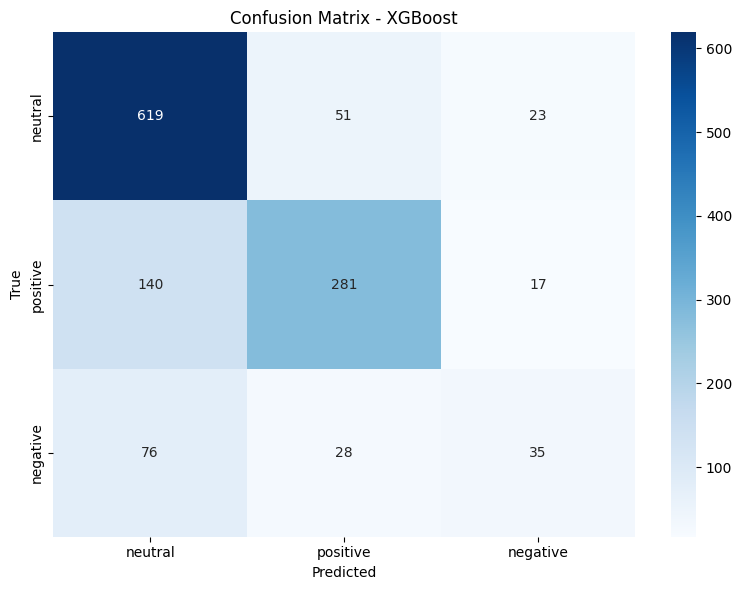


Training Logistic Regression...
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)

Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.16      0.25       139

    accuracy                           0.75      1270
   macro avg       0.71      0.58      0.60      1270
weighted avg       0.74      0.75      0.72      1270


Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.

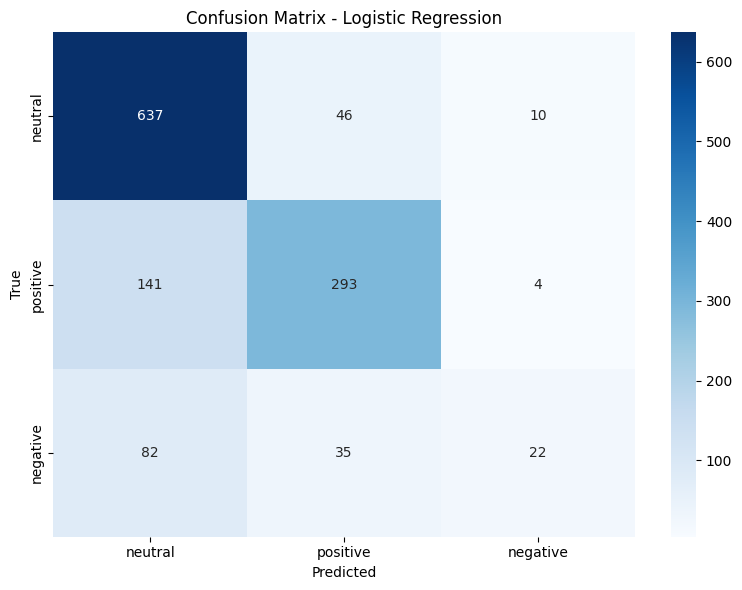


Training Random Forest...
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)

Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31       139

    accuracy                           0.74      1270
   macro avg       0.68      0.59      0.61      1270
weighted avg       0.73      0.74      0.72      1270


Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31      

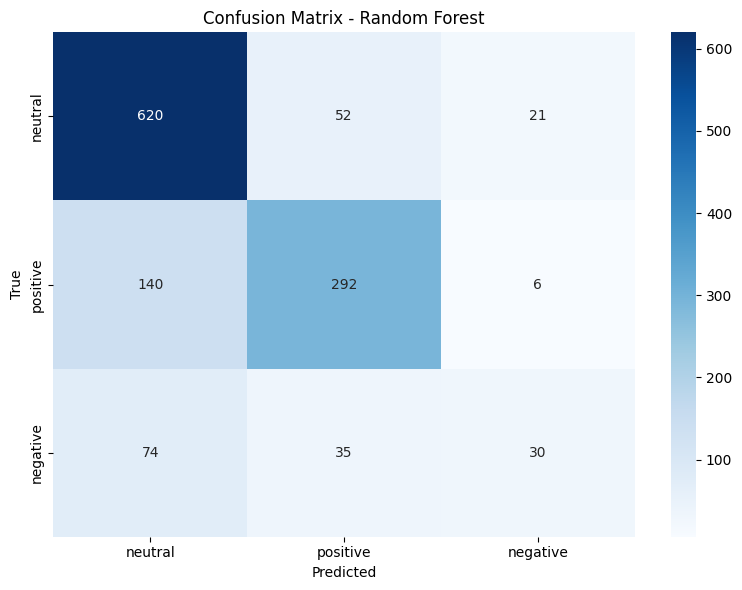


Training SVM...
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)

SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy                           0.74      1270
   macro avg       0.70      0.56      0.58      1270
weighted avg       0.73      0.74      0.71      1270


SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy            

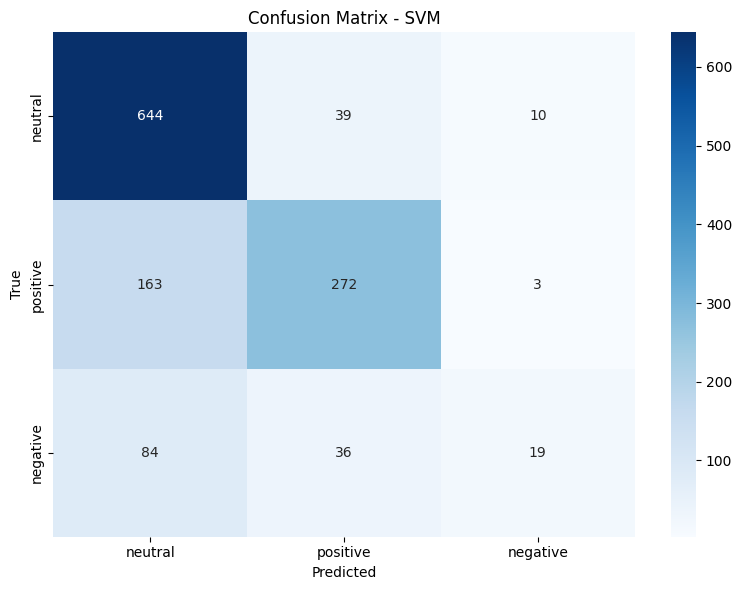


Training Naive Bayes...
Cross-validation scores: [0.68503937 0.71128609 0.70603675 0.68766404 0.70209974]
Mean CV accuracy: 0.6984 (+/- 0.0206)

Naive Bayes Results:
Test Accuracy: 0.7118

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       693
           1       0.70      0.60      0.64       438
           2       0.86      0.04      0.08       139

    accuracy                           0.71      1270
   macro avg       0.76      0.52      0.51      1270
weighted avg       0.73      0.71      0.67      1270

Cross-validation scores: [0.68503937 0.71128609 0.70603675 0.68766404 0.70209974]
Mean CV accuracy: 0.6984 (+/- 0.0206)

Naive Bayes Results:
Test Accuracy: 0.7118

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       693
           1       0.70      0.60      0.64       438
           2       0.86      0.04      0.08       139



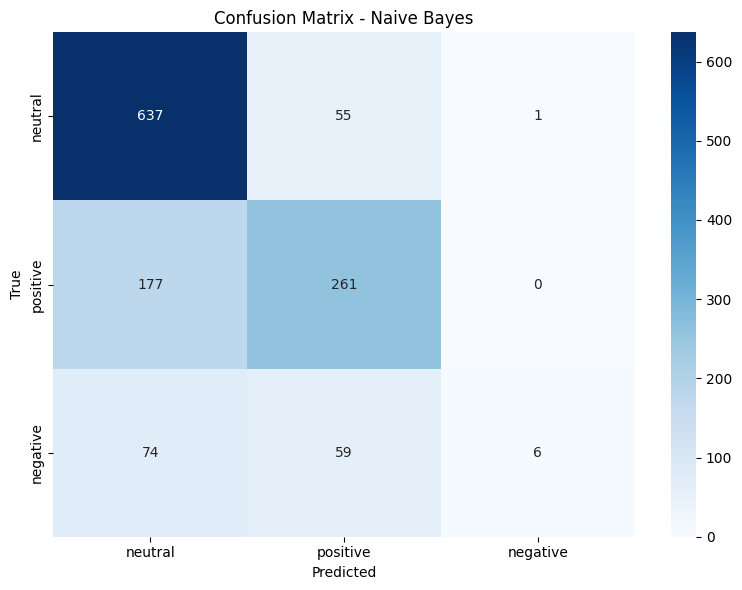


Training XGBoost...
Cross-validation scores: [0.70603675 0.72834646 0.69160105 0.72965879 0.70341207]
Mean CV accuracy: 0.7118 (+/- 0.0297)
Cross-validation scores: [0.70603675 0.72834646 0.69160105 0.72965879 0.70341207]
Mean CV accuracy: 0.7118 (+/- 0.0297)

XGBoost Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.78      0.64      0.70       438
           2       0.47      0.25      0.33       139

    accuracy                           0.74      1270
   macro avg       0.66      0.60      0.61      1270
weighted avg       0.72      0.74      0.72      1270


XGBoost Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.78      0.64      0.70       438
           2       0.47      0.25      0.33       139

    accuracy

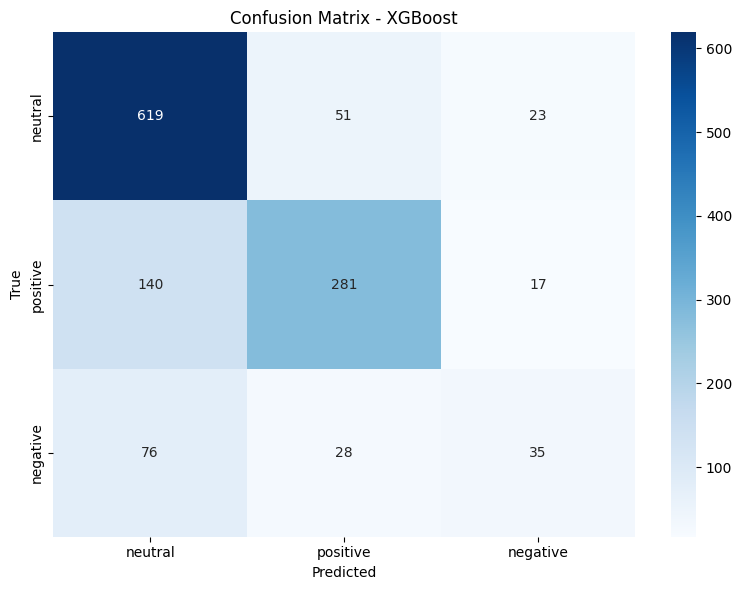


Training LightGBM...
Cross-validation scores: [0.68503937 0.68766404 0.65879265 0.69422572 0.67060367]
Mean CV accuracy: 0.6793 (+/- 0.0256)
Cross-validation scores: [0.68503937 0.68766404 0.65879265 0.69422572 0.67060367]
Mean CV accuracy: 0.6793 (+/- 0.0256)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8859
[LightGBM] [Info] Number of data points in the train set: 3810, number of used features: 470
[LightGBM] [Info] Start training from score -0.606705
[LightGBM] [Info] Start training from score -1.063032
[LightGBM] [Info] Start training from score -2.212298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8859
[LightGBM] [Info] Number of data points in the train set: 3810, number of used features: 47


Training Logistic Regression...
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)

Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.16      0.25       139

    accuracy                           0.75      1270
   macro avg       0.71      0.58      0.60      1270
weighted avg       0.74      0.75      0.72      1270


Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.

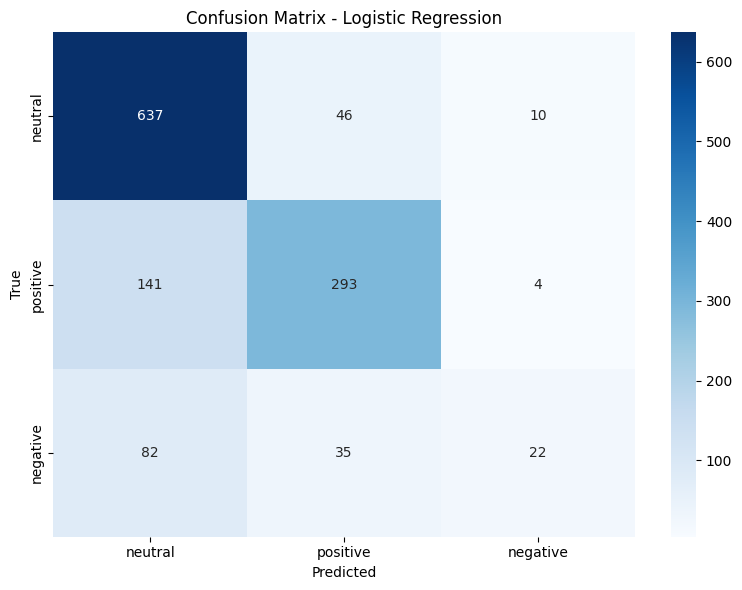


Training Random Forest...
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)

Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31       139

    accuracy                           0.74      1270
   macro avg       0.68      0.59      0.61      1270
weighted avg       0.73      0.74      0.72      1270


Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31      

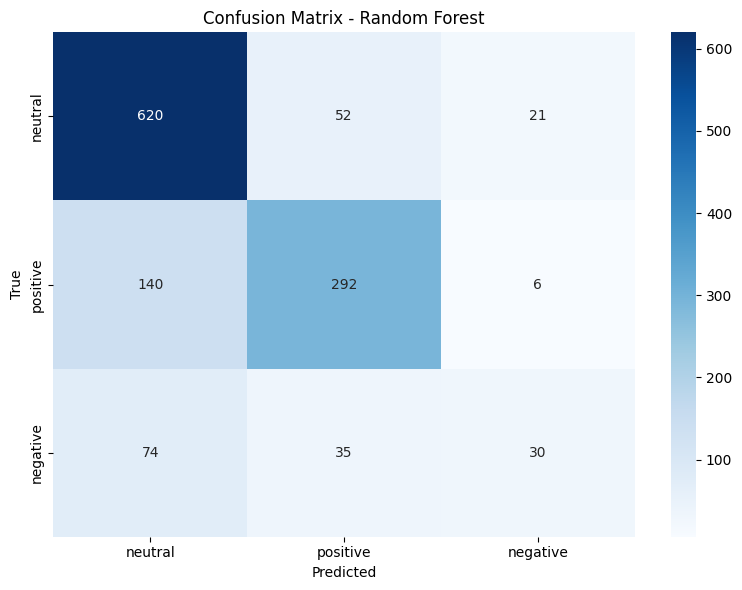


Training SVM...
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)

SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy                           0.74      1270
   macro avg       0.70      0.56      0.58      1270
weighted avg       0.73      0.74      0.71      1270


SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy            

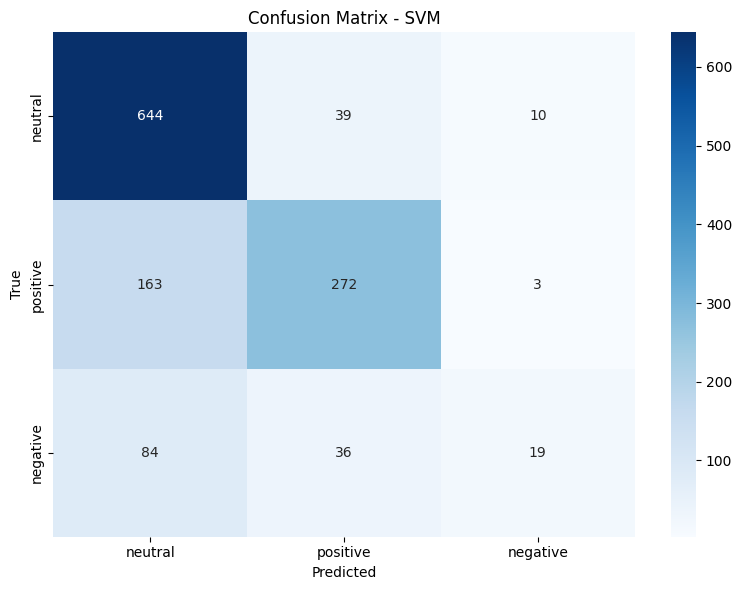


Training Naive Bayes...
Cross-validation scores: [0.68503937 0.71128609 0.70603675 0.68766404 0.70209974]
Mean CV accuracy: 0.6984 (+/- 0.0206)

Naive Bayes Results:
Test Accuracy: 0.7118

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       693
           1       0.70      0.60      0.64       438
           2       0.86      0.04      0.08       139

    accuracy                           0.71      1270
   macro avg       0.76      0.52      0.51      1270
weighted avg       0.73      0.71      0.67      1270

Cross-validation scores: [0.68503937 0.71128609 0.70603675 0.68766404 0.70209974]
Mean CV accuracy: 0.6984 (+/- 0.0206)

Naive Bayes Results:
Test Accuracy: 0.7118

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       693
           1       0.70      0.60      0.64       438
           2       0.86      0.04      0.08       139



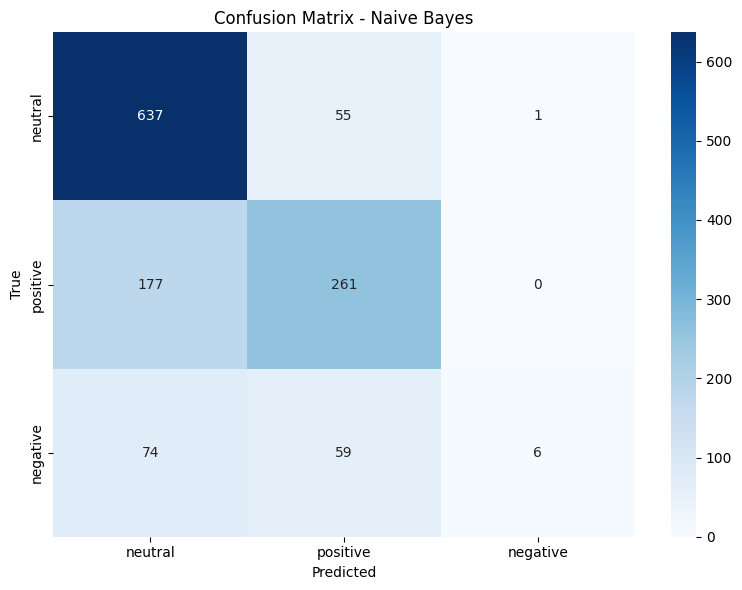


Training XGBoost...
Cross-validation scores: [0.70603675 0.72834646 0.69160105 0.72965879 0.70341207]
Mean CV accuracy: 0.7118 (+/- 0.0297)
Cross-validation scores: [0.70603675 0.72834646 0.69160105 0.72965879 0.70341207]
Mean CV accuracy: 0.7118 (+/- 0.0297)

XGBoost Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.78      0.64      0.70       438
           2       0.47      0.25      0.33       139

    accuracy                           0.74      1270
   macro avg       0.66      0.60      0.61      1270
weighted avg       0.72      0.74      0.72      1270


XGBoost Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.78      0.64      0.70       438
           2       0.47      0.25      0.33       139

    accuracy

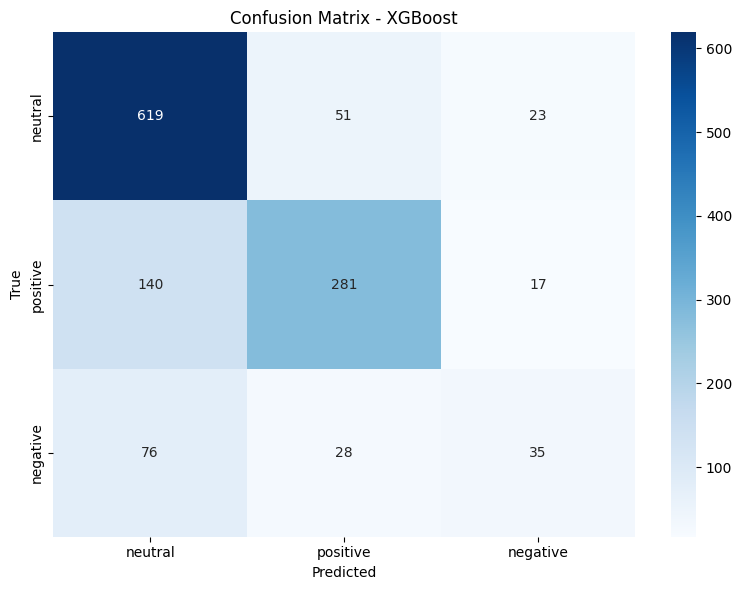


Training LightGBM...
Cross-validation scores: [0.68503937 0.68766404 0.65879265 0.69422572 0.67060367]
Mean CV accuracy: 0.6793 (+/- 0.0256)
Cross-validation scores: [0.68503937 0.68766404 0.65879265 0.69422572 0.67060367]
Mean CV accuracy: 0.6793 (+/- 0.0256)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8859
[LightGBM] [Info] Number of data points in the train set: 3810, number of used features: 470
[LightGBM] [Info] Start training from score -0.606705
[LightGBM] [Info] Start training from score -1.063032
[LightGBM] [Info] Start training from score -2.212298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8859
[LightGBM] [Info] Number of data points in the train set: 3810, number of used features: 47

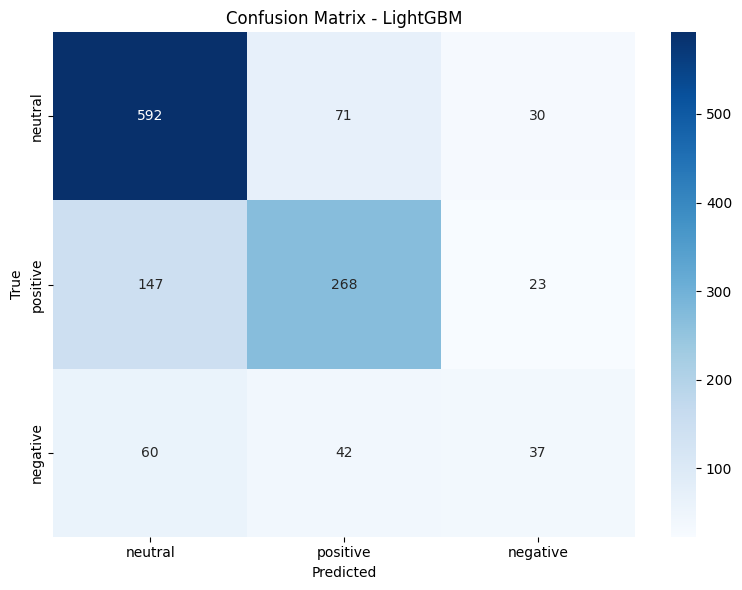


Training Logistic Regression...
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)

Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.16      0.25       139

    accuracy                           0.75      1270
   macro avg       0.71      0.58      0.60      1270
weighted avg       0.74      0.75      0.72      1270


Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.

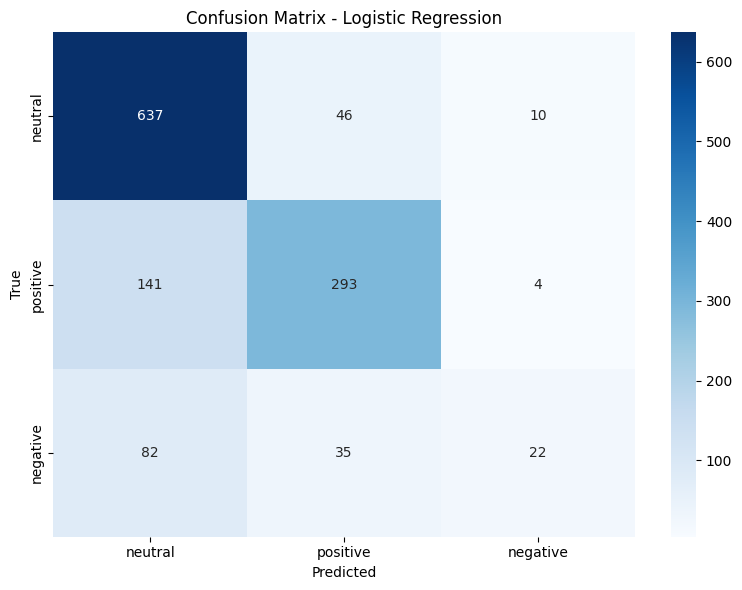


Training Random Forest...
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)

Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31       139

    accuracy                           0.74      1270
   macro avg       0.68      0.59      0.61      1270
weighted avg       0.73      0.74      0.72      1270


Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31      

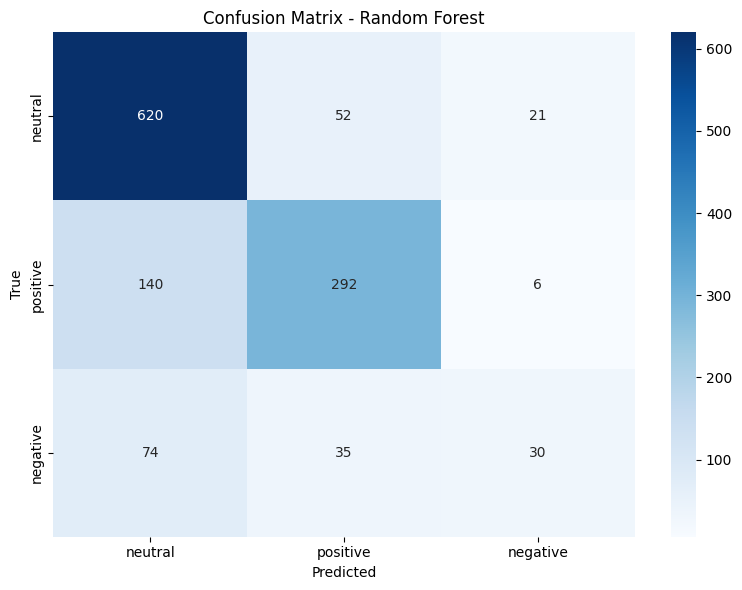


Training SVM...
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)

SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy                           0.74      1270
   macro avg       0.70      0.56      0.58      1270
weighted avg       0.73      0.74      0.71      1270


SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy            

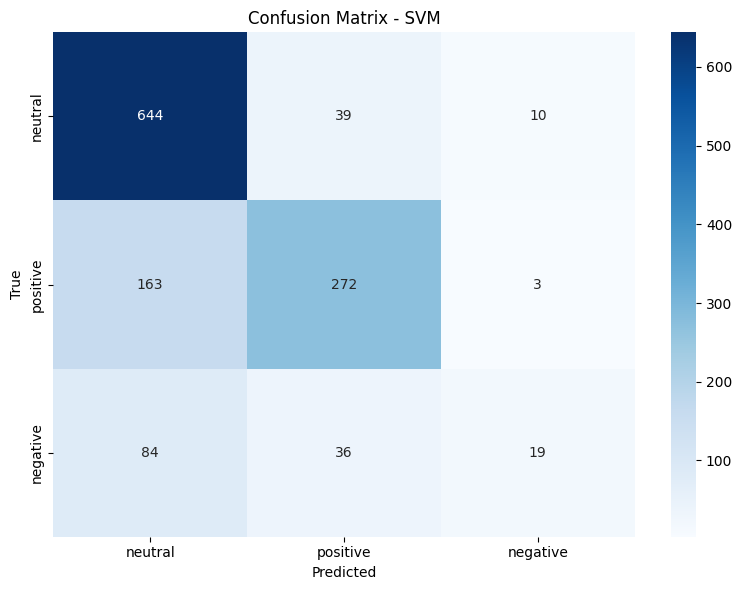


Training Naive Bayes...
Cross-validation scores: [0.68503937 0.71128609 0.70603675 0.68766404 0.70209974]
Mean CV accuracy: 0.6984 (+/- 0.0206)

Naive Bayes Results:
Test Accuracy: 0.7118

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       693
           1       0.70      0.60      0.64       438
           2       0.86      0.04      0.08       139

    accuracy                           0.71      1270
   macro avg       0.76      0.52      0.51      1270
weighted avg       0.73      0.71      0.67      1270

Cross-validation scores: [0.68503937 0.71128609 0.70603675 0.68766404 0.70209974]
Mean CV accuracy: 0.6984 (+/- 0.0206)

Naive Bayes Results:
Test Accuracy: 0.7118

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       693
           1       0.70      0.60      0.64       438
           2       0.86      0.04      0.08       139



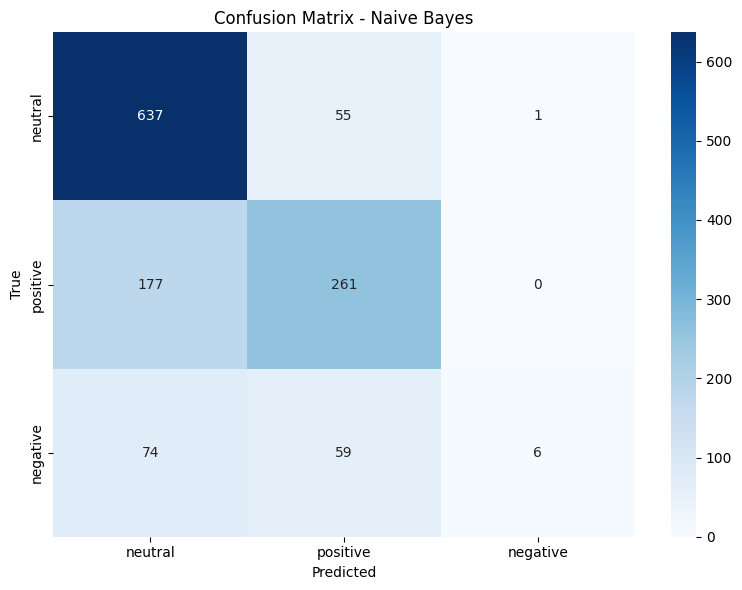


Training XGBoost...
Cross-validation scores: [0.70603675 0.72834646 0.69160105 0.72965879 0.70341207]
Mean CV accuracy: 0.7118 (+/- 0.0297)
Cross-validation scores: [0.70603675 0.72834646 0.69160105 0.72965879 0.70341207]
Mean CV accuracy: 0.7118 (+/- 0.0297)

XGBoost Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.78      0.64      0.70       438
           2       0.47      0.25      0.33       139

    accuracy                           0.74      1270
   macro avg       0.66      0.60      0.61      1270
weighted avg       0.72      0.74      0.72      1270


XGBoost Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.78      0.64      0.70       438
           2       0.47      0.25      0.33       139

    accuracy

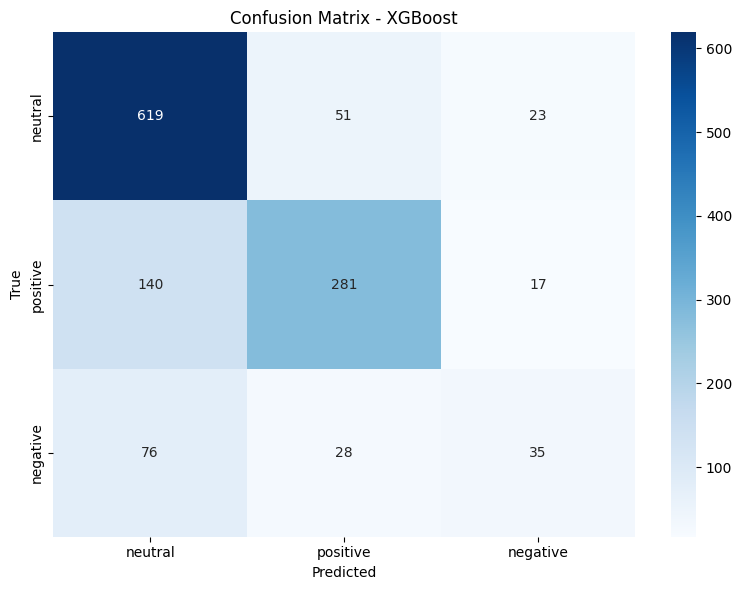


Training LightGBM...
Cross-validation scores: [0.68503937 0.68766404 0.65879265 0.69422572 0.67060367]
Mean CV accuracy: 0.6793 (+/- 0.0256)
Cross-validation scores: [0.68503937 0.68766404 0.65879265 0.69422572 0.67060367]
Mean CV accuracy: 0.6793 (+/- 0.0256)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8859
[LightGBM] [Info] Number of data points in the train set: 3810, number of used features: 470
[LightGBM] [Info] Start training from score -0.606705
[LightGBM] [Info] Start training from score -1.063032
[LightGBM] [Info] Start training from score -2.212298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8859
[LightGBM] [Info] Number of data points in the train set: 3810, number of used features: 47

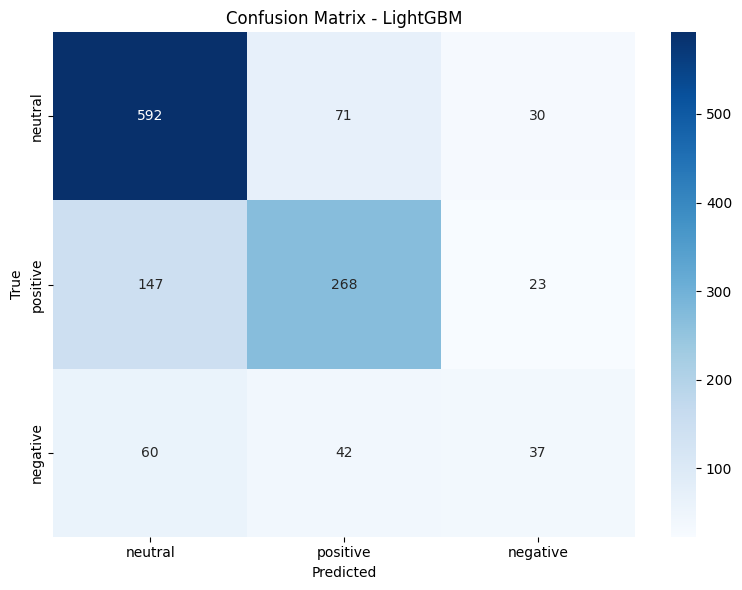

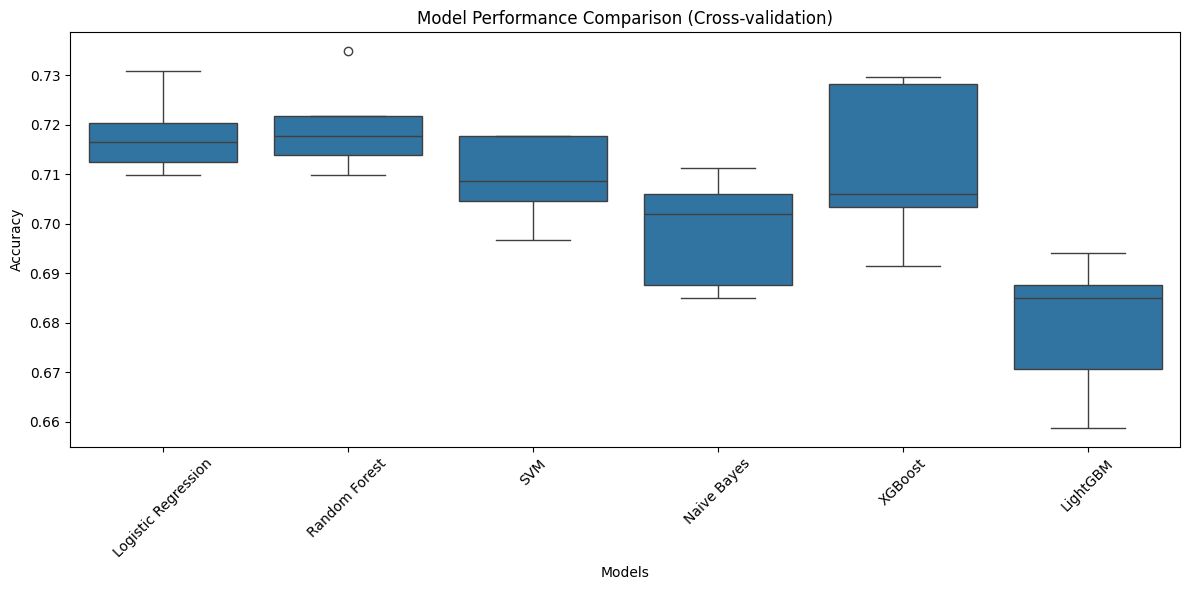


Training Logistic Regression...
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)
Cross-validation scores: [0.70997375 0.73097113 0.71259843 0.72047244 0.71653543]
Mean CV accuracy: 0.7181 (+/- 0.0147)

Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.16      0.25       139

    accuracy                           0.75      1270
   macro avg       0.71      0.58      0.60      1270
weighted avg       0.74      0.75      0.72      1270


Logistic Regression Results:
Test Accuracy: 0.7496

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       693
           1       0.78      0.67      0.72       438
           2       0.61      0.

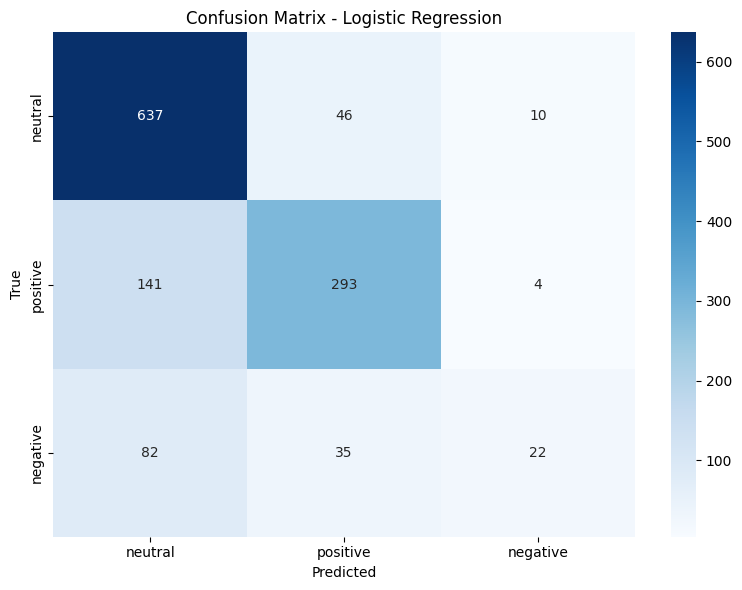


Training Random Forest...
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)
Cross-validation scores: [0.71784777 0.72178478 0.71391076 0.73490814 0.70997375]
Mean CV accuracy: 0.7197 (+/- 0.0171)

Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31       139

    accuracy                           0.74      1270
   macro avg       0.68      0.59      0.61      1270
weighted avg       0.73      0.74      0.72      1270


Random Forest Results:
Test Accuracy: 0.7417

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.77      0.67      0.71       438
           2       0.53      0.22      0.31      

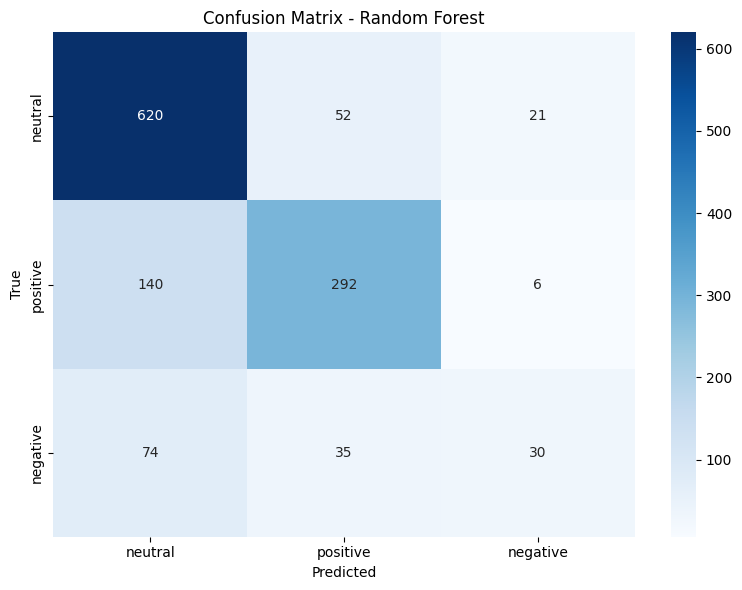


Training SVM...
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)
Cross-validation scores: [0.70866142 0.71784777 0.69685039 0.71784777 0.70472441]
Mean CV accuracy: 0.7092 (+/- 0.0161)

SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy                           0.74      1270
   macro avg       0.70      0.56      0.58      1270
weighted avg       0.73      0.74      0.71      1270


SVM Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       693
           1       0.78      0.62      0.69       438
           2       0.59      0.14      0.22       139

    accuracy            

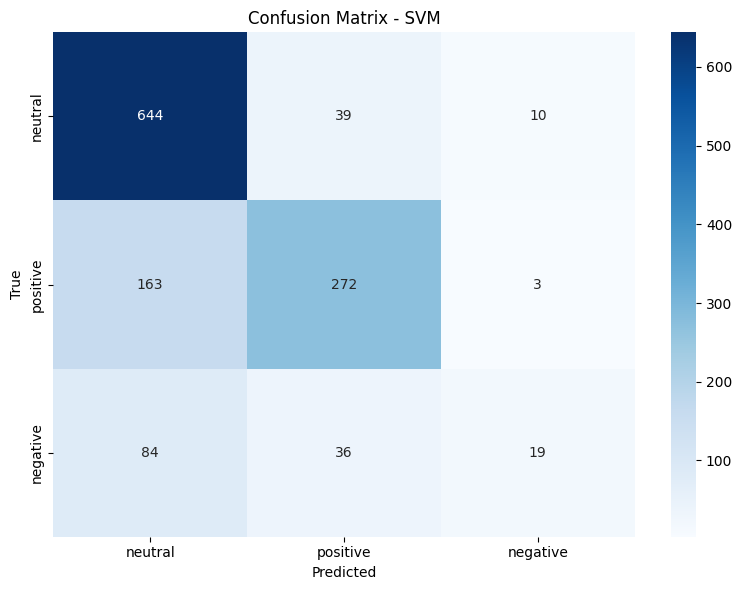


Training Naive Bayes...
Cross-validation scores: [0.68503937 0.71128609 0.70603675 0.68766404 0.70209974]
Mean CV accuracy: 0.6984 (+/- 0.0206)

Naive Bayes Results:
Test Accuracy: 0.7118

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       693
           1       0.70      0.60      0.64       438
           2       0.86      0.04      0.08       139

    accuracy                           0.71      1270
   macro avg       0.76      0.52      0.51      1270
weighted avg       0.73      0.71      0.67      1270

Cross-validation scores: [0.68503937 0.71128609 0.70603675 0.68766404 0.70209974]
Mean CV accuracy: 0.6984 (+/- 0.0206)

Naive Bayes Results:
Test Accuracy: 0.7118

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       693
           1       0.70      0.60      0.64       438
           2       0.86      0.04      0.08       139



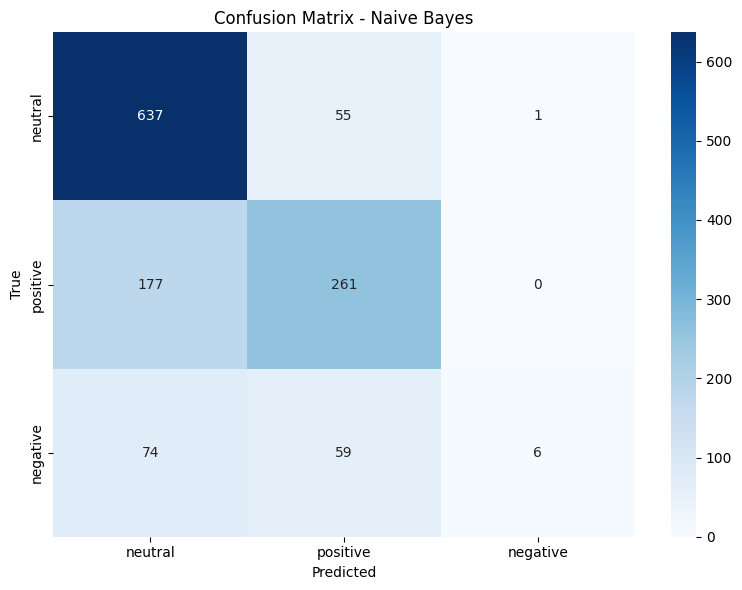


Training XGBoost...
Cross-validation scores: [0.70603675 0.72834646 0.69160105 0.72965879 0.70341207]
Mean CV accuracy: 0.7118 (+/- 0.0297)
Cross-validation scores: [0.70603675 0.72834646 0.69160105 0.72965879 0.70341207]
Mean CV accuracy: 0.7118 (+/- 0.0297)

XGBoost Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.78      0.64      0.70       438
           2       0.47      0.25      0.33       139

    accuracy                           0.74      1270
   macro avg       0.66      0.60      0.61      1270
weighted avg       0.72      0.74      0.72      1270


XGBoost Results:
Test Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       693
           1       0.78      0.64      0.70       438
           2       0.47      0.25      0.33       139

    accuracy

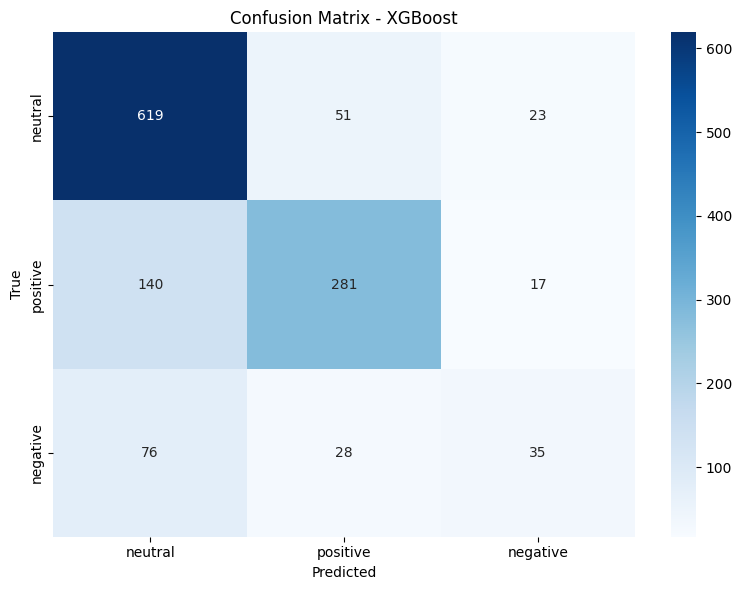


Training LightGBM...
Cross-validation scores: [0.68503937 0.68766404 0.65879265 0.69422572 0.67060367]
Mean CV accuracy: 0.6793 (+/- 0.0256)
Cross-validation scores: [0.68503937 0.68766404 0.65879265 0.69422572 0.67060367]
Mean CV accuracy: 0.6793 (+/- 0.0256)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8859
[LightGBM] [Info] Number of data points in the train set: 3810, number of used features: 470
[LightGBM] [Info] Start training from score -0.606705
[LightGBM] [Info] Start training from score -1.063032
[LightGBM] [Info] Start training from score -2.212298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8859
[LightGBM] [Info] Number of data points in the train set: 3810, number of used features: 47

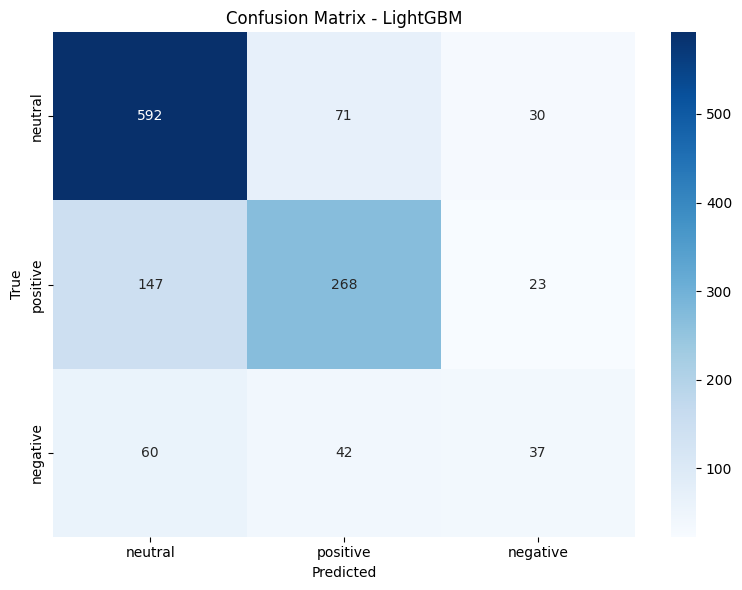

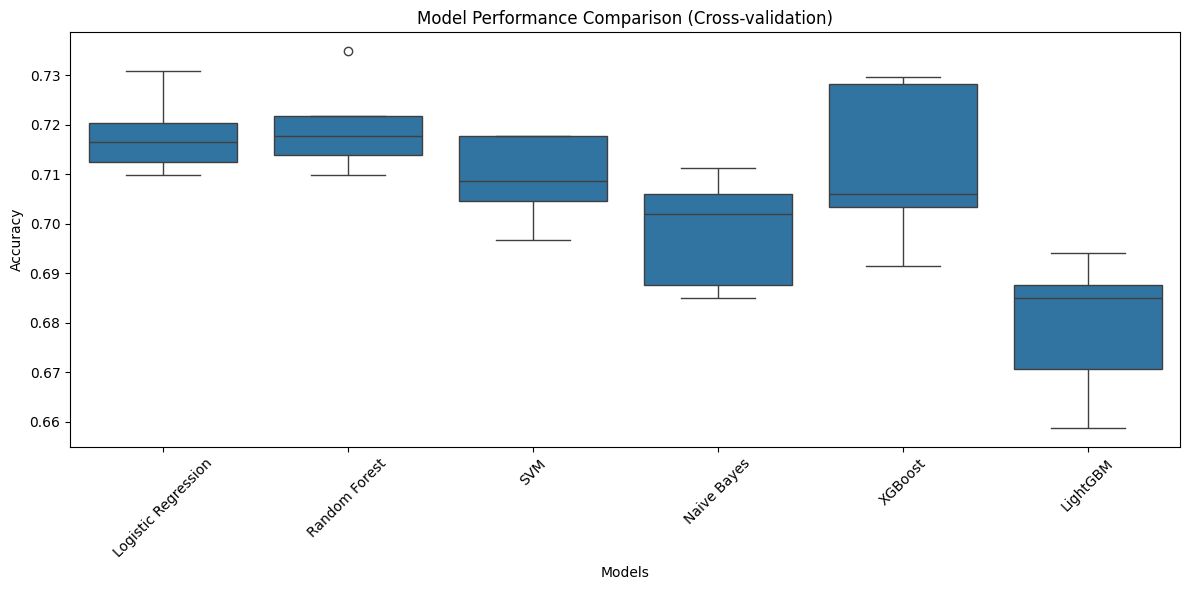

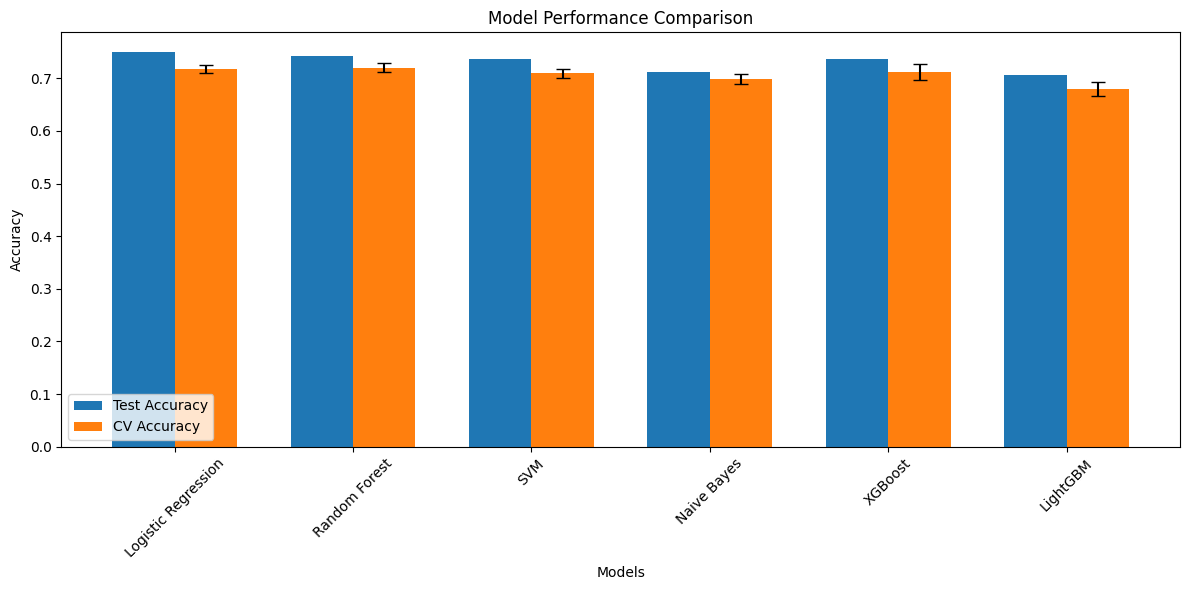


Top 3 performing models:

Logistic Regression:
Test Accuracy: 0.7496
Mean CV Accuracy: 0.7181

Random Forest:
Test Accuracy: 0.7417
Mean CV Accuracy: 0.7197

SVM:
Test Accuracy: 0.7362
Mean CV Accuracy: 0.7092


In [7]:
# Initialize models with multiclass-specific configurations
models = {
    'Logistic Regression': LogisticRegression(
        multi_class='multinomial',  # Specific for multiclass
        solver='lbfgs',            # Best solver for multinomial
        max_iter=1000,             # Increased for convergence
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,          # Default value
        criterion='gini',          # Default, good for multiclass
        random_state=42
    ),
    'SVM': SVC(
        kernel='rbf',              # Default value
        decision_function_shape='ovo',  # One-vs-one for multiclass
        probability=True,          # Enable probability estimates
        random_state=42
    ),
    'Naive Bayes': MultinomialNB(),
    'XGBoost': xgb.XGBClassifier(
        objective='multi:softmax',  # Specific for multiclass
        num_class=3,               # Number of classes
        random_state=42
    ),
    'LightGBM': lgb.LGBMClassifier(
        objective='multiclass',     # Specific for multiclass
        num_class=3,               # Number of classes
        random_state=42
    )
}

# Dictionary to store results
results = {}

# Create StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate each model
for name, model in models.items():
    try:
        print(f"\nTraining {name}...")
        
        # Perform cross-validation
        cv_scores = cross_val_score(
            model, 
            X_train_tfidf,
            y_train, 
            cv=skf, 
            scoring='accuracy',
            n_jobs=-1
        )
        
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train the model on full training data
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
        
        # Store results
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'cv_scores': cv_scores
        }
        
        # Print results
        print(f"\n{name} Results:")
        print(f"Test Accuracy: {results[name]['accuracy']:.4f}")
        print("\nClassification Report:")
        print(results[name]['classification_report'])
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sentiment_names = ['neutral', 'positive', 'negative']  # Ordered by their numeric values (0,1,2)
        sns.heatmap(results[name]['confusion_matrix'], 
                   annot=True, 
                   fmt='d', 
                   cmap='Blues',
                   xticklabels=sentiment_names,
                   yticklabels=sentiment_names)
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"\nError training {name}:")
        print(str(e))
        continue

# Create a more detailed comparison plot
plt.figure(figsize=(12, 6))

# Box plot for cross-validation scores
cv_data = []
model_names = []
for name in results.keys():
    cv_data.extend(results[name]['cv_scores'])
    model_names.extend([name] * len(results[name]['cv_scores']))

sns.boxplot(x=model_names, y=cv_data)
plt.title('Model Performance Comparison (Cross-validation)')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot for test accuracy with error bars from CV
plt.figure(figsize=(12, 6))
test_accuracies = [results[name]['accuracy'] for name in results.keys()]
cv_means = [results[name]['cv_scores'].mean() for name in results.keys()]
cv_stds = [results[name]['cv_scores'].std() for name in results.keys()]

x = np.arange(len(results))
width = 0.35

plt.bar(x - width/2, test_accuracies, width, label='Test Accuracy')
plt.bar(x + width/2, cv_means, width, label='CV Accuracy')
plt.errorbar(x + width/2, cv_means, yerr=cv_stds, fmt='none', color='black', capsize=5)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(x, list(results.keys()), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Find the top 3 performing models
if results:
    sorted_models = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)[:3]
    print("\nTop 3 performing models:")
    for name, result in sorted_models:
        print(f"\n{name}:")
        print(f"Test Accuracy: {result['accuracy']:.4f}")
        print(f"Mean CV Accuracy: {result['cv_scores'].mean():.4f}")
    
    # Store top 3 model names for later use
    top_3_models = [name for name, _ in sorted_models]
else:
    print("\nNo models were successfully trained")

## Hyperparameter Optimization for Top 3 Models

In [11]:
# Define parameter grids for top 3 models
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
        'multi_class': ['multinomial'],
        'max_iter': [1000, 2000]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto'],
        'class_weight': ['balanced', None]
    },
    'Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0, 2.0],
        'fit_prior': [True, False]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    'LightGBM': {
        'num_leaves': [31, 63, 127],
        'max_depth': [5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [200, 300, 400],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'min_child_samples': [20, 40, 60]
    },
    'XGBoost': {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
}

Optimizing first model: Logistic Regression
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters for Logistic Regression:
{'C': 10, 'max_iter': 1000, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Best cross-validation accuracy: 0.7213
Test accuracy: 0.7339

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       693
           1       0.73      0.70      0.72       438
           2       0.47      0.29      0.36       139

    accuracy                           0.73      1270
   macro avg       0.66      0.61      0.63      1270
weighted avg       0.72      0.73      0.72      1270


Best parameters for Logistic Regression:
{'C': 10, 'max_iter': 1000, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Best cross-validation accuracy: 0.7213
Test accuracy: 0.7339

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       

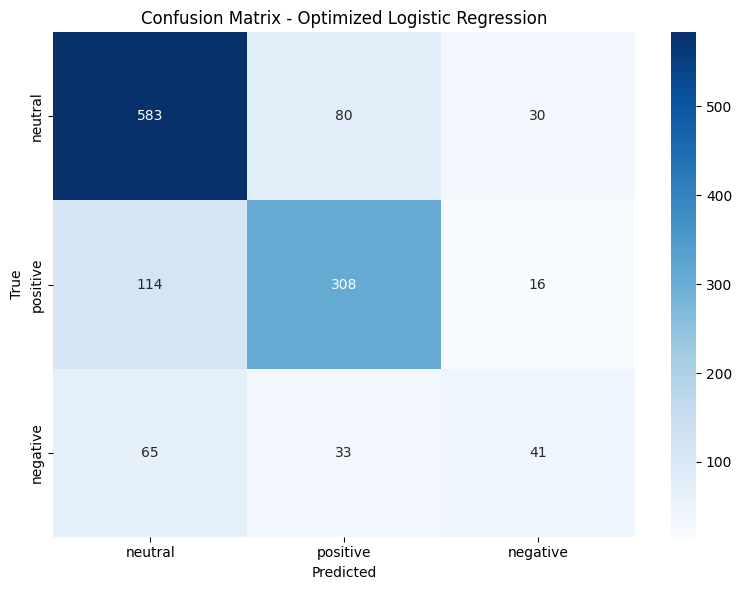

In [12]:
# Hyperparameter optimization for the best performing model (1st)
print("Optimizing first model:", top_3_models[0])
first_model = models[top_3_models[0]]
first_grid = GridSearchCV(
    estimator=first_model,
    param_grid=param_grids[top_3_models[0]],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the model
first_grid.fit(X_train_tfidf, y_train)

# Print results
print(f"\nBest parameters for {top_3_models[0]}:")
print(first_grid.best_params_)
print(f"Best cross-validation accuracy: {first_grid.best_score_:.4f}")

# Evaluate on test set
y_pred = first_grid.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['neutral', 'positive', 'negative'],
            yticklabels=['neutral', 'positive', 'negative'])
plt.title(f'Confusion Matrix - Optimized {top_3_models[0]}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
# Hyperparameter optimization for the second best model
print("\nOptimizing second model:", top_3_models[1])
second_model = models[top_3_models[1]]
second_grid = GridSearchCV(
    estimator=second_model,
    param_grid=param_grids[top_3_models[1]],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the model
second_grid.fit(X_train_tfidf, y_train)

# Print results
print(f"\nBest parameters for {top_3_models[1]}:")
print(second_grid.best_params_)
print(f"Best cross-validation accuracy: {second_grid.best_score_:.4f}")

# Evaluate on test set
y_pred = second_grid.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['neutral', 'positive', 'negative'],
            yticklabels=['neutral', 'positive', 'negative'])
plt.title(f'Confusion Matrix - Optimized {top_3_models[1]}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
# Hyperparameter optimization for the third best model
print("\nOptimizing third model:", top_3_models[2])
third_model = models[top_3_models[2]]
third_grid = GridSearchCV(
    estimator=third_model,
    param_grid=param_grids[top_3_models[2]],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the model
third_grid.fit(X_train_tfidf, y_train)

# Print results
print(f"\nBest parameters for {top_3_models[2]}:")
print(third_grid.best_params_)
print(f"Best cross-validation accuracy: {third_grid.best_score_:.4f}")

# Evaluate on test set
y_pred = third_grid.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['neutral', 'positive', 'negative'],
            yticklabels=['neutral', 'positive', 'negative'])
plt.title(f'Confusion Matrix - Optimized {top_3_models[2]}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Model Testing

In [ ]:
# Compare cross-validation scores from hyperparameter tuning
cv_scores = {
    top_3_models[0]: first_grid.best_score_,
    top_3_models[1]: second_grid.best_score_,
    top_3_models[2]: third_grid.best_score_
}

# Get the name of the best performing model
best_model_name = max(cv_scores.items(), key=lambda x: x[1])[0]
print(f"\nBest performing model after hyperparameter tuning: {best_model_name}")
print(f"Best cross-validation score: {cv_scores[best_model_name]:.4f}")

# Create a dictionary of optimized models
optimized_models = {
    top_3_models[0]: first_grid.best_estimator_,
    top_3_models[1]: second_grid.best_estimator_,
    top_3_models[2]: third_grid.best_estimator_
}

# Assign the best model to best_model variable
best_model = optimized_models[best_model_name]
print("\nBest model parameters:")
print(best_model.get_params())

In [9]:
# Function for predicting sentiment of new texts
def predict_sentiment(text):
    # Preprocess text
    processed = preprocess_text(text)
    # TF-IDF transformation and convert to dense array
    text_tfidf = tfidf.transform([processed]).toarray()
    
    # Get numeric prediction
    prediction_encoded = best_model.predict(text_tfidf)[0]
    
    # Convert numeric prediction to sentiment label
    sentiment_labels = {0: 'neutral', 1: 'positive', 2: 'negative'}
    prediction = sentiment_labels[prediction_encoded]
    
    return prediction

In [ ]:
# Test examples
test_texts = [
    "Stock market reaches all-time high as tech sector booms",
    "Company announces massive layoffs amid financial troubles",
    "Market remains stable as Fed maintains current interest rates"
]

# Make predictions on test examples
print("Test Results:")
for text in test_texts:
    sentiment = predict_sentiment(text)
    print(f"\nText: {text}")
    print(f"Predicted sentiment: {sentiment}")

## Model Save

In [ ]:
# Define the directory to save the model
model_dir = '../models/'
os.makedirs(model_dir, exist_ok=True)

# Define the path for the saved model file
model_path = os.path.join(model_dir, 'sentiment_model.pkl')

# Save the best performing model
joblib.dump(best_model, model_path)

print(f"Best performing model saved to: {model_path}")

In [ ]:
# Load the saved model
loaded_model_path = '../models/sentiment_model.pkl'
loaded_model = joblib.load(loaded_model_path)

# Test with a new text
new_text = "The company's earnings report exceeded expectations."
predicted_sentiment = predict_sentiment(new_text)

print(f"\nNew text: {new_text}")
print(f"Predicted sentiment: {predicted_sentiment}")